# Experimento de Ablacion
Dataset: MERDWild

In [1]:
import os 
from glob import glob 
import numpy as np  
import pandas as pd
from IPython.display import Audio 
from scipy.special import softmax 
import cv2
from skimage.color import rgb2gray
import matplotlib.pyplot as plt 
from matplotlib import colormaps 
from matplotlib.colors import Normalize 
from tqdm import tqdm  
import pickle  
from skimage.io import imread 
from skimage.util import img_as_float32, random_noise 
from skimage.transform import resize_local_mean, rotate
from skimage.color import gray2rgb 
import librosa  
from sklearn.neural_network import MLPClassifier
from functools import reduce
from sklearn import metrics
import torch 
from torch import nn 
from torch.optim import Adam 
from torch.autograd import Variable 
from torch.nn import functional as F 
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50 
from sentence_transformers import SentenceTransformer 
from transformers import BertModel, BertConfig, TransfoXLModel, XLNetModel 
import warnings

## Obtencion de Features
Tenemos que obtener las features de los datos de entrenamiento y validacion. De modo de tener todos los ejemplos para cada uterancia de emoción.
Idealmente, tendriamos que identificar desde los archivos de datos de AffWild, identificar las uterancias, de modo de tener el evento exacto para obtener las features por arquitectura.

In [2]:
labelnames = ['Neutral', 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
labeldict = {label: i for i, label in enumerate(labelnames)}

### Creacion de Dataset

In [3]:
# # Raices del dataset
# def open_MERDWild_image_df(path, root=""):
#     # Lee un archivo CSV en un DataFrame
#     df_0 = pd.read_csv(path, sep=',', index_col='Index')
#     df = df_0[df_0['Image_Filter'] == 1].copy()  # Usar solo imágenes de buena calidad
#     df['Filepath'] = root_path + "\\" + df['KEY']

#     # Verifica la existencia de los archivos en las rutas especificadas.
#     existing_files = [os.path.join(root, impath) for impath in df['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]

#     # Filtra el DataFrame para incluir solo las entradas con archivos existentes.
#     df = df[df['Filepath'].isin(existing_files)]
# #     percentage = 0.30
# #     # Utiliza el método 'sample' para obtener una muestra aleatoria del 10%
# #     df = df.sample(frac=percentage, random_state=42)    
#     return df

def open_MERDWild_image_df(path, root=""):
    df_0 = pd.read_csv(path, sep=',')
    df = df_0[df_0['Image_Filter'] == 1].copy() 
    df['Filepath'] = root_path + "\\" + df['KEY']
    df.reset_index(drop=True, inplace=True)
    df.index.name = 'Index'
    existing_files = [os.path.join(root, impath) for impath in df['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]
    df = df[df['Filepath'].isin(existing_files)]
    #     percentage = 0.30
    #     # Utiliza el método 'sample' para obtener una muestra aleatoria del 30%
    #     df = df.sample(frac=percentage, random_state=42)    
    return df

# Raices del dataset
def open_MERDWild_audio_df(path, root=""):
    df_0 = pd.read_csv(path, sep=',')
    #df = df_0[df_0['Audio_Filter'] == 1].copy()  # Usar solo imágenes de buena calidad
    df_0['Filepath'] = root_path + "\\" + df_0['KEY']
    df_0.reset_index(drop=True, inplace=True)
    df_0.index.name = 'Index'
    existing_files = [os.path.join(root, impath) for impath in df_0['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]
    df_0 = df_0[df_0['Filepath'].isin(existing_files)]
#     percentage = 0.30
#     # Utiliza el método 'sample' para obtener una muestra aleatoria del 30%
#     df = df.sample(frac=percentage, random_state=42)    
    return df_0

## Cambiar ruta de BD

In [4]:
root_path = r"D:\Datasets\MERDWild"

#### No modificar

In [5]:
import os
save_pickle = root_path + "\\" + r"trained_models\faces" 

if not os.path.exists(save_pickle):
    os.makedirs(save_pickle)
    print(f"La carpeta '{save_pickle}' ha sido creada.")
else:
    print(f"La carpeta '{save_pickle}' ya existe.")

La carpeta 'D:\Datasets\MERDWild\trained_models\faces' ya existe.


In [6]:
# train_audio_file = root_path + "\\" + r"Training\Calidad_Audios_Unificados_TRAIN.csv"
# valid_audio_file = root_path + "\\" + r"Validation\Calidad_Audios_Unificados_VAL.csv"

# train_face_file = root_path + "\\" + r"Training\Calidad_Imagenes_Unificadas_TRAIN.csv"
# valid_face_file = root_path + "\\" + r"Validation\Calidad_Imagenes_Unificadas_VAL.csv"

train_audio_file = root_path + "\\" + r"Test\audios_train.csv"
valid_audio_file = root_path + "\\" + r"Test\audios_valid.csv"

train_face_file = root_path + "\\" + r"Test\imagenes_train.csv"
valid_face_file = root_path + "\\" + r"Test\imagenes_valid.csv"

train_csv = root_path + "\\" + r"trainembrace.csv"
val_csv = root_path + "\\" + r"validembrace.csv"

solo_img_pth = save_pickle + "\\" + r"Face_MERDWild.pth"
solo_audios_pth = save_pickle + "\\" + r"MERDWild_audio.pth"

valid_text = save_pickle + "\\" + "valid_text_feats.pkl"
train_text = save_pickle + "\\" + "train_text_feats.pkl"

valid_audios = save_pickle + "\\" + r"valid_audio_feats.pkl"
train_audios = save_pickle + "\\" + r"train_audio_feats.pkl"

valid_img = save_pickle + "\\" + r"valid_image_feats.pkl"
train_img = save_pickle + "\\" + r"train_image_feats.pkl"

train_audio = open_MERDWild_audio_df(train_audio_file)
valid_audio = open_MERDWild_audio_df(valid_audio_file)

trainface = open_MERDWild_image_df(train_face_file)
validface = open_MERDWild_image_df(valid_face_file)

traindf = pd.DataFrame(columns=["filename", "impath", "AudioDuration", "label", "ilabel", "Text"])
validdf = pd.DataFrame(columns=["filename", "impath", "AudioDuration", "label", "ilabel", "Text"])

print(f"Para audios: Entrenamiento {len(train_audio)}, y validacion {len(valid_audio)}")
print(f"Para caras: Entrenamiento {len(trainface)}, y validacion {len(validface)}")

Para audios: Entrenamiento 5275, y validacion 2262
Para caras: Entrenamiento 460566, y validacion 199005


In [7]:
train_audio.head()

Unnamed: 0  Index  File_Name_Ext  Duration  Average_Power_Level  \
Index                                                                    
0               2      4             24      2.16           -29.237429   
1               3      5             25      1.96           -25.821160   
2               4      8             28      4.42           -14.134349   
3               5      9             29      2.88           -31.252164   
4               9     14             36      2.88           -44.733513   

       Peak_Level  Total_Harmonic_Distortion  Signal_to_Noise_Ratio  \
Index                                                                 
0      -13.203463                  35.403899              -3.837866   
1      -14.849370                  38.290037              -3.944483   
2       -2.735591                  42.541154              -3.613527   
3      -13.416970                  34.795057              -3.927169   
4      -35.115642                  42.093126              -1.073460   

       First_Filter  Failures  ...                                    Tokens  \
Index                          ...                                             
0                 1         0  ...                  ['idiom', 'made', 'sin']   
1                 1         0  ...  ['supposing', 'want', 'make', 'flowers']   
2                 1         0  ...               ['hand', 'always', 'scarf']   
3                 1         0  ...                                  ['gold']   
4                 0         2  ...                                ['miller']   

                             Lemmatized_Tokens                    KEY  \
Index                                                                   
0                     ['idiom', 'make', 'sin']  Test\Audios\00024.wav   
1      ['supposing', 'want', 'make', 'flower']  Test\Audios\00025.wav   
2                  ['hand', 'always', 'scarf']  Test\Audios\00028.wav   
3                                     ['gold']  Test\Audios\00029.wav   
4                                   ['miller']  Test\Audios\00036.wav   

      Semantic_Filter Text_Filter  Emotion   Set  Source_DB  Folder  \
Index                                                                 
0            0.092920           1    Happy  test       MAFW      24   
1            0.200587           1    Angry  test       MAFW      25   
2            0.173771           1    Angry  test       MAFW      28   
3            0.105035           1  Neutral  test       MAFW      29   
4            0.176124           0  Neutral  test       MAFW      36   

                                         Filepath  
Index                                              
0      D:\Datasets\MERDWild\Test\Audios\00024.wav  
1      D:\Datasets\MERDWild\Test\Audios\00025.wav  
2      D:\Datasets\MERDWild\Test\Audios\00028.wav  
3      D:\Datasets\MERDWild\Test\Audios\00029.wav  
4      D:\Datasets\MERDWild\Test\Audios\00036.wav  

[5 rows x 24 columns]

In [8]:
train_audio.columns

Index(['Unnamed: 0', 'Index', 'File_Name_Ext', 'Duration',
       'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion',
       'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Lemmatized_Tokens', 'KEY', 'Semantic_Filter', 'Text_Filter',
       'Emotion', 'Set', 'Source_DB', 'Folder', 'Filepath'],
      dtype='object')

In [9]:
df_text = train_audio.loc[train_audio['Text_Filter'] == 1, ['KEY', 'Emotion', 'Text_Filter', 'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens', 'Filepath']].copy()
df_audio = train_audio.loc[train_audio['Audio_Filter'] == 1, ['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter']].copy()

df_text

KEY   Emotion  Text_Filter  \
Index                                                 
0      Test\Audios\00024.wav     Happy            1   
1      Test\Audios\00025.wav     Angry            1   
2      Test\Audios\00028.wav     Angry            1   
3      Test\Audios\00029.wav   Neutral            1   
5      Test\Audios\00037.wav   Neutral            1   
...                      ...       ...          ...   
5269   Test\Audios\20089.wav  Surprise            1   
5271   Test\Audios\20091.wav  Surprise            1   
5272   Test\Audios\20093.wav     Happy            1   
5273   Test\Audios\20094.wav  Surprise            1   
5274   Test\Audios\20096.wav  Surprise            1   

                                           Transcription  \
Index                                                      
0                  WHAT AN IDIOM WE HAVE MADE OF THE SIN   
1                 SUPPOSING I DON'T WANT TO MAKE FLOWERS   
2                           MY HAND IS ALWAYS OF A SCARF   
3                                       OF THE SAME GOLD   
5                  AND I KNOW THAT WE JUST MET YESTERDAY   
...                                                  ...   
5269   DOLLARS AND THAT'S IF WE WIN FIFTEEN THOUSAND ...   
5271                             THE MAN I'M WAITING FOR   
5272                                    I'M I'M STARVING   
5273                            OH MY GOD YOU DON'T KNOW   
5274                                   O MY GOD O MY GOD   

                                 Lowercase_Transcription  \
Index                                                      
0                  what an idiom we have made of the sin   
1                supposing i do not want to make flowers   
2                           my hand is always of a scarf   
3                                       of the same gold   
5                  and i know that we just met yesterday   
...                                                  ...   
5269   dollars and that is if we win fifteen thousand...   
5271                            the man i am waiting for   
5272                                  i am i am starving   
5273                           oh my god you do not know   
5274                                   o my god o my god   

                     Text_Without_Stopwords  \
Index                                         
0                            idiom made sin   
1               supposing want make flowers   
2                         hand always scarf   
3                                      gold   
5                        know met yesterday   
...                                     ...   
5269   dollars win fifteen thousand dollars   
5271                            man waiting   
5272                               starving   
5273                            oh god know   
5274                                god god   

                                                  Tokens  Semantic_Filter  \
Index                                                                       
0                               ['idiom', 'made', 'sin']         0.092920   
1               ['supposing', 'want', 'make', 'flowers']         0.200587   
2                            ['hand', 'always', 'scarf']         0.173771   
3                                               ['gold']         0.105035   
5                           ['know', 'met', 'yesterday']         0.126828   
...                                                  ...              ...   
5269   ['dollars', 'win', 'fifteen', 'thousand', 'dol...         0.145707   
5271                                  ['man', 'waiting']         0.123659   
5272                                        ['starving']         0.133135   
5273                               ['oh', 'god', 'know']         0.168787   
5274                                      ['god', 'god']         0.160173   

      Source_DB   Set                                  Lemmatized_Tokens  \
Index                                                    

In [10]:
df_audio

KEY   Emotion  File_Name_Ext  Duration  \
Index                                                             
0      Test\Audios\00024.wav     Happy             24      2.16   
1      Test\Audios\00025.wav     Angry             25      1.96   
2      Test\Audios\00028.wav     Angry             28      4.42   
3      Test\Audios\00029.wav   Neutral             29      2.88   
5      Test\Audios\00037.wav   Neutral             37      2.25   
...                      ...       ...            ...       ...   
5269   Test\Audios\20089.wav  Surprise          20089      3.24   
5271   Test\Audios\20091.wav  Surprise          20091      1.92   
5272   Test\Audios\20093.wav     Happy          20093      3.40   
5273   Test\Audios\20094.wav  Surprise          20094      2.32   
5274   Test\Audios\20096.wav  Surprise          20096      3.12   

       Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
Index                                                               
0               -29.237429  -13.203463                  35.403899   
1               -25.821160  -14.849370                  38.290037   
2               -14.134349   -2.735591                  42.541154   
3               -31.252164  -13.416970                  34.795057   
5               -36.454609  -25.012642                  39.825508   
...                    ...         ...                        ...   
5269            -37.279763  -23.389768                  38.076746   
5271            -31.784362  -19.452490                  37.695779   
5272            -36.571509  -20.065988                  35.102330   
5273            -34.401585  -16.795265                  35.521142   
5274            -37.872771  -24.301437                  38.494210   

       Signal_to_Noise_Ratio  First_Filter  Failures  Audio_Filter  
Index                                                               
0                  -3.837866             1         0             1  
1                  -3.944483             1         0             1  
2                  -3.613527             1         0             1  
3                  -3.927169             1         0             1  
5                  -3.947772             1         0             1  
...                      ...           ...       ...           ...  
5269               -3.943781             1         0             1  
5271               -3.856245             1         0             1  
5272               -3.941978             1         0             1  
5273               -3.944418             1         0             1  
5274               -3.940927             1         0             1  

[4598 rows x 11 columns]

In [11]:
train_audio = pd.merge(df_audio, df_text, left_on=['KEY', 'Emotion'], right_on=['KEY', 'Emotion'], how='outer')
train_audio

KEY   Emotion  File_Name_Ext  Duration  \
0     Test\Audios\00024.wav     Happy             24      2.16   
1     Test\Audios\00025.wav     Angry             25      1.96   
2     Test\Audios\00028.wav     Angry             28      4.42   
3     Test\Audios\00029.wav   Neutral             29      2.88   
4     Test\Audios\00037.wav   Neutral             37      2.25   
...                     ...       ...            ...       ...   
4593  Test\Audios\20089.wav  Surprise          20089      3.24   
4594  Test\Audios\20091.wav  Surprise          20091      1.92   
4595  Test\Audios\20093.wav     Happy          20093      3.40   
4596  Test\Audios\20094.wav  Surprise          20094      2.32   
4597  Test\Audios\20096.wav  Surprise          20096      3.12   

      Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
0              -29.237429  -13.203463                  35.403899   
1              -25.821160  -14.849370                  38.290037   
2              -14.134349   -2.735591                  42.541154   
3              -31.252164  -13.416970                  34.795057   
4              -36.454609  -25.012642                  39.825508   
...                   ...         ...                        ...   
4593           -37.279763  -23.389768                  38.076746   
4594           -31.784362  -19.452490                  37.695779   
4595           -36.571509  -20.065988                  35.102330   
4596           -34.401585  -16.795265                  35.521142   
4597           -37.872771  -24.301437                  38.494210   

      Signal_to_Noise_Ratio  First_Filter  Failures  ...  Text_Filter  \
0                 -3.837866             1         0  ...          1.0   
1                 -3.944483             1         0  ...          1.0   
2                 -3.613527             1         0  ...          1.0   
3                 -3.927169             1         0  ...          1.0   
4                 -3.947772             1         0  ...          1.0   
...                     ...           ...       ...  ...          ...   
4593              -3.943781             1         0  ...          1.0   
4594              -3.856245             1         0  ...          1.0   
4595              -3.941978             1         0  ...          1.0   
4596              -3.944418             1         0  ...          1.0   
4597              -3.940927             1         0  ...          1.0   

                                          Transcription  \
0                 WHAT AN IDIOM WE HAVE MADE OF THE SIN   
1                SUPPOSING I DON'T WANT TO MAKE FLOWERS   
2                          MY HAND IS ALWAYS OF A SCARF   
3                                      OF THE SAME GOLD   
4                 AND I KNOW THAT WE JUST MET YESTERDAY   
...                                                 ...   
4593  DOLLARS AND THAT'S IF WE WIN FIFTEEN THOUSAND ...   
4594                            THE MAN I'M WAITING FOR   
4595                                   I'M I'M STARVING   
4596                           OH MY GOD YOU DON'T KNOW   
4597                                  O MY GOD O MY GOD   

                                Lowercase_Transcription  \
0                 what an idiom we have made of the sin   
1               supposing i do not want to make flowers   
2                          my hand is always of a scarf   
3                                      of the same gold   
4                 and i know that we just met yesterday   
...                                                 ...   
4593  dollars and that is if we win fifteen thousand...   
4594                           the man i am waiting for   
4595                                 i am i am starving   
4596                          oh my god you do not know   
4597                                  o my god o my god   

                    Text_Without_Stopwords  \
0                           idiom made sin   
1              supposing wa

In [12]:
train_audio.columns

Index(['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level',
       'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio',
       'First_Filter', 'Failures', 'Audio_Filter', 'Text_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens',
       'Filepath'],
      dtype='object')

In [13]:
train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].astype(str)

# Quita la palabra ".wav" de la columna "File_Name_Ext" en train_audio
#train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].str.replace('.wav', '')


# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].str.zfill(5)
train_audio

KEY   Emotion File_Name_Ext  Duration  \
0     Test\Audios\00024.wav     Happy         00024      2.16   
1     Test\Audios\00025.wav     Angry         00025      1.96   
2     Test\Audios\00028.wav     Angry         00028      4.42   
3     Test\Audios\00029.wav   Neutral         00029      2.88   
4     Test\Audios\00037.wav   Neutral         00037      2.25   
...                     ...       ...           ...       ...   
4593  Test\Audios\20089.wav  Surprise         20089      3.24   
4594  Test\Audios\20091.wav  Surprise         20091      1.92   
4595  Test\Audios\20093.wav     Happy         20093      3.40   
4596  Test\Audios\20094.wav  Surprise         20094      2.32   
4597  Test\Audios\20096.wav  Surprise         20096      3.12   

      Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
0              -29.237429  -13.203463                  35.403899   
1              -25.821160  -14.849370                  38.290037   
2              -14.134349   -2.735591                  42.541154   
3              -31.252164  -13.416970                  34.795057   
4              -36.454609  -25.012642                  39.825508   
...                   ...         ...                        ...   
4593           -37.279763  -23.389768                  38.076746   
4594           -31.784362  -19.452490                  37.695779   
4595           -36.571509  -20.065988                  35.102330   
4596           -34.401585  -16.795265                  35.521142   
4597           -37.872771  -24.301437                  38.494210   

      Signal_to_Noise_Ratio  First_Filter  Failures  ...  Text_Filter  \
0                 -3.837866             1         0  ...          1.0   
1                 -3.944483             1         0  ...          1.0   
2                 -3.613527             1         0  ...          1.0   
3                 -3.927169             1         0  ...          1.0   
4                 -3.947772             1         0  ...          1.0   
...                     ...           ...       ...  ...          ...   
4593              -3.943781             1         0  ...          1.0   
4594              -3.856245             1         0  ...          1.0   
4595              -3.941978             1         0  ...          1.0   
4596              -3.944418             1         0  ...          1.0   
4597              -3.940927             1         0  ...          1.0   

                                          Transcription  \
0                 WHAT AN IDIOM WE HAVE MADE OF THE SIN   
1                SUPPOSING I DON'T WANT TO MAKE FLOWERS   
2                          MY HAND IS ALWAYS OF A SCARF   
3                                      OF THE SAME GOLD   
4                 AND I KNOW THAT WE JUST MET YESTERDAY   
...                                                 ...   
4593  DOLLARS AND THAT'S IF WE WIN FIFTEEN THOUSAND ...   
4594                            THE MAN I'M WAITING FOR   
4595                                   I'M I'M STARVING   
4596                           OH MY GOD YOU DON'T KNOW   
4597                                  O MY GOD O MY GOD   

                                Lowercase_Transcription  \
0                 what an idiom we have made of the sin   
1               supposing i do not want to make flowers   
2                          my hand is always of a scarf   
3                                      of the same gold   
4                 and i know that we just met yesterday   
...                                                 ...   
4593  dollars and that is if we win fifteen thousand...   
4594                           the man i am waiting for   
4595                                 i am i am starving   
4596                          oh my god you do not know   
4597                                  o my god o my god   

                    Text_Without_Stopwords  \
0                           idiom made sin   
1              supposing want make flow

In [14]:
trainface['Folder'] = trainface['Folder'].astype(str)

# Quita la palabra ".wav" de la columna "File_Name_Ext" en train_audio
#trainface['File_Name_Ext'] = trainface['File_Name_Ext'].str.replace('.wav', '')


# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
trainface['Folder'] = trainface['Folder'].str.zfill(5)
trainface


Unnamed: 0                                               Ruta  \
Index                                                                   
0               56  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
1               57  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
2               58  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
3               59  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
4               60  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
...            ...                                                ...   
460561      856930  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
460562      856931  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
460563      856932  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
460564      856933  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
460565      856934  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   

                                     KEY  Simility_HOG_cos  First_Filter  \
Index                                                                      
0        Test\Imagenes\00024\frame_1.jpg          0.981268             1   
1       Test\Imagenes\00024\frame_10.jpg          0.984785             1   
2       Test\Imagenes\00024\frame_11.jpg          0.989015             1   
3       Test\Imagenes\00024\frame_12.jpg          0.987078             1   
4       Test\Imagenes\00024\frame_13.jpg          0.988190             1   
...                                  ...               ...           ...   
460561  Test\Imagenes\20096\frame_80.jpg          0.979479             1   
460562  Test\Imagenes\20096\frame_81.jpg          0.985621             1   
460563  Test\Imagenes\20096\frame_82.jpg          0.985809             1   
460564  Test\Imagenes\20096\frame_83.jpg          0.972992             1   
460565   Test\Imagenes\20096\frame_9.jpg          0.972992             1   

        Brightness    Contrast   Entropy  Facial_Points        Blur  Failures  \
Index                                                                           
0       203.654132  194.345963  5.578698             55  194.345963         0   
1       203.180862  201.063994  5.647879             80  201.063994         0   
2       202.320295  185.923502  5.620756             56  185.923502         0   
3       200.710592  184.257759  5.593580             75  184.257759         0   
4       201.215680  176.701424  5.613727             71  176.701424         0   
...            ...         ...       ...            ...         ...       ...   
460561   54.189072   30.016909  4.678306             92   30.016909         0   
460562   54.282661   22.423202  4.664064             73   22.423202         0   
460563   53.918241   28.526545  4.776208            105   28.526545         0   
460564   53.690236   24.507970  4.784690             95   24.507970         0   
460565   52.984845   32.684187  4.721159             82   32.684187         0   

         Emotion   Set Source_DB  Height  Width  Image_Filter Folder  \
Index                                                                  
0          Happy  test      MAFW     126    126             1  00024   
1          Happy  test      MAFW     121    121             1  00024   
2          Happy  test      MAFW     126    126             1  00024   
3          Happy  test      MAFW     130    130             1  00024   
4          Happy  test      MAFW     125    125             1  00024   
...          ...   ...       ...     ...    ...           ...    ...   
460561  Surprise  test      MAFW     344    344             1  20096   
460562  Surprise  test      MAFW     346    346             1  20096   
460563  Surprise  test      MAFW     328    328             1  20096   
460564  Surprise  test      MAFW     334    334             1  20096   
460565  Surprise  test      MAFW     293    293             1  20096   

                                                 Filepath  
Index             

In [15]:
# Realiza la unión utilizando dos columnas coincidentes y la columna "Emotion" como adicional
union_train_df = pd.merge(train_audio, trainface, left_on=['File_Name_Ext', 'Emotion'], right_on=['Folder', 'Emotion'], how='outer')
union_train_df

KEY_x Emotion File_Name_Ext  Duration  \
0       Test\Audios\00024.wav   Happy         00024      2.16   
1       Test\Audios\00024.wav   Happy         00024      2.16   
2       Test\Audios\00024.wav   Happy         00024      2.16   
3       Test\Audios\00024.wav   Happy         00024      2.16   
4       Test\Audios\00024.wav   Happy         00024      2.16   
...                       ...     ...           ...       ...   
460915                    NaN     Sad           NaN       NaN   
460916                    NaN     Sad           NaN       NaN   
460917                    NaN     Sad           NaN       NaN   
460918                    NaN     Sad           NaN       NaN   
460919                    NaN     Sad           NaN       NaN   

        Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
0                -29.237429  -13.203463                  35.403899   
1                -29.237429  -13.203463                  35.403899   
2                -29.237429  -13.203463                  35.403899   
3                -29.237429  -13.203463                  35.403899   
4                -29.237429  -13.203463                  35.403899   
...                     ...         ...                        ...   
460915                  NaN         NaN                        NaN   
460916                  NaN         NaN                        NaN   
460917                  NaN         NaN                        NaN   
460918                  NaN         NaN                        NaN   
460919                  NaN         NaN                        NaN   

        Signal_to_Noise_Ratio  First_Filter_x  Failures_x  ...  Facial_Points  \
0                   -3.837866             1.0         0.0  ...           55.0   
1                   -3.837866             1.0         0.0  ...           80.0   
2                   -3.837866             1.0         0.0  ...           56.0   
3                   -3.837866             1.0         0.0  ...           75.0   
4                   -3.837866             1.0         0.0  ...           71.0   
...                       ...             ...         ...  ...            ...   
460915                    NaN             NaN         NaN  ...          225.0   
460916                    NaN             NaN         NaN  ...          217.0   
460917                    NaN             NaN         NaN  ...          227.0   
460918                    NaN             NaN         NaN  ...          212.0   
460919                    NaN             NaN         NaN  ...          226.0   

              Blur Failures_y Set_y Source_DB_y Height  Width Image_Filter  \
0       194.345963        0.0  test        MAFW  126.0  126.0          1.0   
1       201.063994        0.0  test        MAFW  121.0  121.0          1.0   
2       185.923502        0.0  test        MAFW  126.0  126.0          1.0   
3       184.257759        0.0  test        MAFW  130.0  130.0          1.0   
4       176.701424        0.0  test        MAFW  125.0  125.0          1.0   
...            ...        ...   ...         ...    ...    ...          ...   
460915   51.046171        0.0  test        MAFW  512.0  512.0          1.0   
460916   51.115058        0.0  test        MAFW  509.0  509.0          1.0   
460917   53.604281        0.0  test        MAFW  498.0  498.0          1.0   
460918   56.412748        0.0  test        MAFW  494.0  494.0          1.0   
460919   56.690849        0.0  test        MAFW  505.0  505.0          1.0   

       Folder                                         Filepath_y  
0       00024  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...  
1       00024  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...  
2       00024  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...  
3       00024  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...  
4       00024  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...  
...       ...                                                ...  
460915  15598  D:\Datas

In [16]:
union_train_df.columns

Index(['KEY_x', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level',
       'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio',
       'First_Filter_x', 'Failures_x', 'Audio_Filter', 'Text_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Semantic_Filter', 'Source_DB_x', 'Set_x',
       'Lemmatized_Tokens', 'Filepath_x', 'Unnamed: 0', 'Ruta', 'KEY_y',
       'Simility_HOG_cos', 'First_Filter_y', 'Brightness', 'Contrast',
       'Entropy', 'Facial_Points', 'Blur', 'Failures_y', 'Set_y',
       'Source_DB_y', 'Height', 'Width', 'Image_Filter', 'Folder',
       'Filepath_y'],
      dtype='object')

In [17]:
# import matplotlib.pyplot as plt
# import pandas as pd

# null_counts_train = union_train_df.isnull().sum()

# plt.figure(figsize=(39, 6))
# null_counts_train.plot(kind='bar')
# plt.title('Valores Nulos por Columna')
# plt.xlabel('Columna')
# plt.ylabel('Cantidad de Valores Nulos')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [18]:
#print(null_counts_train)

<IPython.core.display.Javascript object>


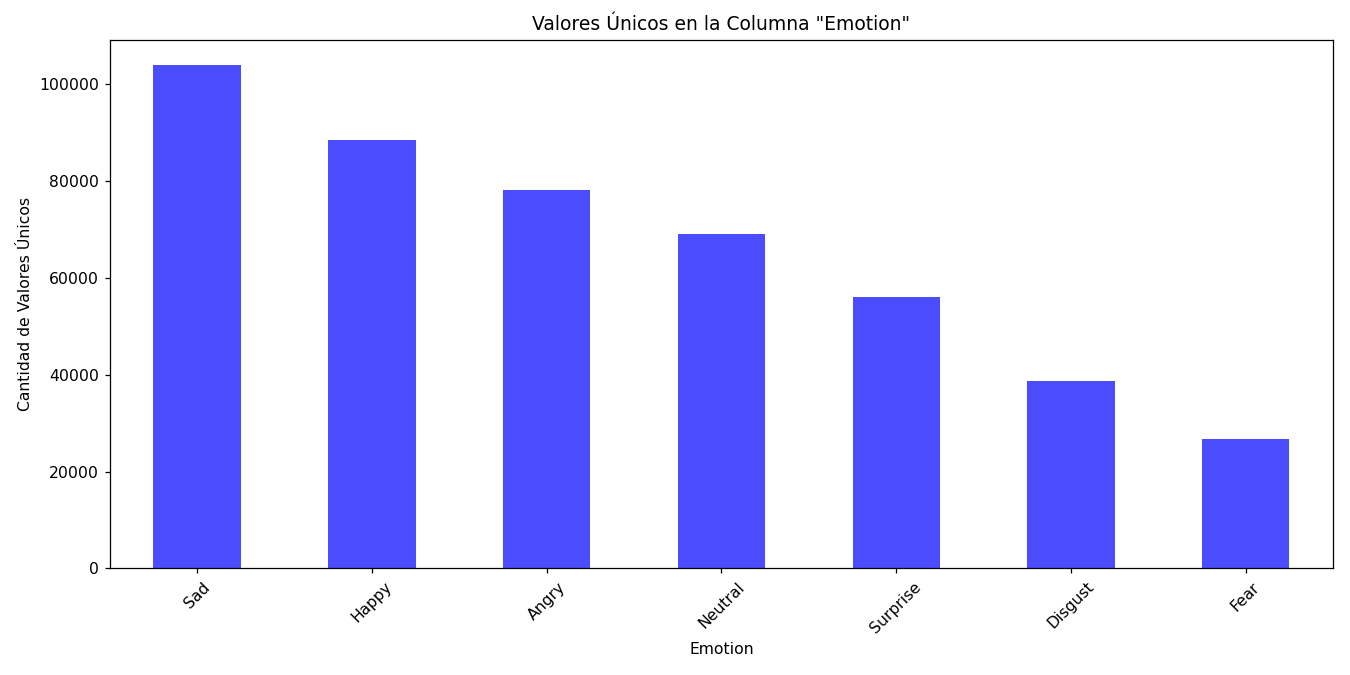

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

emotion_counts = union_train_df['Emotion'].value_counts()

%matplotlib notebook

plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Valores Únicos en la Columna "Emotion"')
plt.xlabel('Emotion')
plt.ylabel('Cantidad de Valores Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# No es necesario ejecutar esta parte pq ya tengo los resultados de la union de la primera ejecución

In [20]:
# # Tipo de datos a procesar (entrenamiento)
# kind = "Train"

# # Directorio raíz de los recortes (crops)
# #croproot = os.path.join(root_path, f"{kind}Crop")


# # Itera a través de las filas (utensilios) en el DataFrame 'trainaudio'
# for sel in tqdm(union_train_df.itertuples()):
    
#     # Construye la ruta al archivo de recorte (crop) correspondiente
#     croppath = sel.Filepath_y
    
#     # Busca todos los archivos de recorte que coincidan con la ruta
#     #crops = glob(croppath)
    
#     # Si no hay recortes disponibles para este diálogo y frase, continúa con la siguiente iteración
#     #if len(crops) == 0:
#     #    continue
    
#     # Etiqueta de emoción del hablante
#     label = sel.Emotion
    
#     # Índice de la etiqueta en 'labelnames' (diccionario de etiquetas)
#     ilabel = labeldict[label]
    
#     # Ruta al archivo de audio correspondiente a este diálogo y frase
#     audiopath = sel.Filepath_x
    
#     # Duración del audio obtenida con librosa
#     audio_duration = sel.Duration
    
#     # Texto (utterance) asociado al hablante
#     texts = sel.Lemmatized_Tokens
    
#     # Crea un DataFrame con la información recopilada
#     rowdf = pd.DataFrame({
#         "filename": audiopath,
#         "impath": croppath,
#         "AudioDuration": audio_duration,
#         "label": label,
#         "Text": texts, 
#         "ilabel": ilabel,
#     }, index=pd.Index([0]))

#     # Concatena el DataFrame 'rowdf' al DataFrame 'traindf'
#     traindf = pd.concat([traindf, rowdf], ignore_index=True)
    
# # Guarda el DataFrame 'traindf' en un archivo CSV
# traindf.to_csv(train_csv, sep='|', float_format='%.3f') 

# Acá ocupo lo de arriba y me ahorro tiempo

In [21]:
traindf = pd.read_csv(train_csv, sep='|', index_col='Unnamed: 0')
traindf

filename  \
0       D:\Datasets\MERDWild\Test\Audios\00024.wav   
1       D:\Datasets\MERDWild\Test\Audios\00024.wav   
2       D:\Datasets\MERDWild\Test\Audios\00024.wav   
3       D:\Datasets\MERDWild\Test\Audios\00024.wav   
4       D:\Datasets\MERDWild\Test\Audios\00024.wav   
...                                            ...   
460915                                         NaN   
460916                                         NaN   
460917                                         NaN   
460918                                         NaN   
460919                                         NaN   

                                                   impath  AudioDuration  \
0       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
1       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
2       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
3       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
4       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
...                                                   ...            ...   
460915  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460916  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460917  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460918  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460919  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   

        label  ilabel                      Text  
0       Happy       4  ['idiom', 'make', 'sin']  
1       Happy       4  ['idiom', 'make', 'sin']  
2       Happy       4  ['idiom', 'make', 'sin']  
3       Happy       4  ['idiom', 'make', 'sin']  
4       Happy       4  ['idiom', 'make', 'sin']  
...       ...     ...                       ...  
460915    Sad       5                       NaN  
460916    Sad       5                       NaN  
460917    Sad       5                       NaN  
460918    Sad       5                       NaN  
460919    Sad       5                       NaN  

[460920 rows x 6 columns]

In [22]:
df_text_valid = valid_audio.loc[valid_audio['Text_Filter'] == 1, ['KEY', 'Emotion', 'Text_Filter', 'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens', 'Filepath']].copy()
df_audio_valid = valid_audio.loc[valid_audio['Audio_Filter'] == 1, ['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter']].copy()

df_text_valid

KEY   Emotion  Text_Filter  \
Index                                                 
1      Test\Audios\00020.wav   Neutral            1   
3      Test\Audios\00034.wav   Neutral            1   
4      Test\Audios\00035.wav     Happy            1   
5      Test\Audios\00041.wav  Surprise            1   
6      Test\Audios\00059.wav   Disgust            1   
...                      ...       ...          ...   
2257   Test\Audios\20086.wav  Surprise            1   
2258   Test\Audios\20092.wav  Surprise            1   
2259   Test\Audios\20095.wav   Disgust            1   
2260   Test\Audios\20097.wav     Angry            1   
2261   Test\Audios\20098.wav  Surprise            1   

                                           Transcription  \
Index                                                      
1      TO ME ABOUT IT CONFRONTED ME BEFORE I LEFT FOR...   
3                       EXTREME MEASURES SEEM REASONABLE   
4       MARRIED PROFESSIONAL OR CLOSELY RELATED TO ME SO   
5      I THINK I'M AFRAID IT'S A GREAT JOB WITH THOSE...   
6      ALL RIGHT HE THOUGHT IT SHOULD HAVE A ROTTEN L...   
...                                                  ...   
2257                        JESUS CHRIST WITH THE BUCKET   
2258                                          HOORAY NOW   
2259               YOU'VE ONLY SHED WHAT DID YOU GIVE ME   
2260                                              ERMINE   
2261                    AS IF YOU KNOW ANYTHING ABOUT IT   

                                 Lowercase_Transcription  \
Index                                                      
1      to me about it confronted me before i left for...   
3                       extreme measures seem reasonable   
4       married professional or closely related to me so   
5      i think i am afraid it is a great job with tho...   
6      all right he thought it should have a rotten l...   
...                                                  ...   
2257                        jesus christ with the bucket   
2258                                          hooray now   
2259             you have only shed what did you give me   
2260                                              ermine   
2261                    as if you know anything about it   

                     Text_Without_Stopwords  \
Index                                         
1                    confronted left africa   
3          extreme measures seem reasonable   
4      married professional closely related   
5                think afraid great job sea   
6      right thought rotten look making fat   
...                                     ...   
2257                    jesus christ bucket   
2258                                 hooray   
2259                              shed give   
2260                                 ermine   
2261                          know anything   

                                                  Tokens  Semantic_Filter  \
Index                                                                       
1                       ['confronted', 'left', 'africa']         0.151797   
3          ['extreme', 'measures', 'seem', 'reasonable']         0.160951   
4      ['married', 'professional', 'closely', 'related']         0.156847   
5             ['think', 'afraid', 'great', 'job', 'sea']         0.101010   
6      ['right', 'thought', 'rotten', 'look', 'making...         0.156171   
...                                                  ...              ...   
2257                       ['jesus', 'christ', 'bucket']         0.126240   
2258                                          ['hooray']         0.208258   
2259                                    ['shed', 'give']         0.101682   
2260                                          ['ermine']         0.170784   
2261                                ['know', 'anything']         0.169088   

      Source_DB   Set                                  Lemmatized_Tokens  \
Index                                                    

In [23]:
df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].astype(str)

# Quita la palabra ".wav" de la columna "File_Name_Ext" en train_audio
#df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].str.replace('.wav', '')


# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].str.zfill(5)
df_audio_valid

KEY   Emotion File_Name_Ext  Duration  \
Index                                                            
0      Test\Audios\00019.wav   Neutral         00019      1.84   
1      Test\Audios\00020.wav   Neutral         00020      4.88   
3      Test\Audios\00034.wav   Neutral         00034      2.63   
4      Test\Audios\00035.wav     Happy         00035      4.88   
5      Test\Audios\00041.wav  Surprise         00041      2.84   
...                      ...       ...           ...       ...   
2257   Test\Audios\20086.wav  Surprise         20086      2.44   
2258   Test\Audios\20092.wav  Surprise         20092      0.96   
2259   Test\Audios\20095.wav   Disgust         20095      2.36   
2260   Test\Audios\20097.wav     Angry         20097      1.16   
2261   Test\Audios\20098.wav  Surprise         20098      2.36   

       Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
Index                                                               
0               -21.864116   -7.560650                  34.629384   
1               -23.990850   -8.933411                  38.493229   
3               -31.143815  -19.006216                  39.517619   
4               -29.757301  -13.679282                  37.238939   
5               -25.759159  -15.963912                  41.106185   
...                    ...         ...                        ...   
2257            -29.394605  -17.283438                  40.210053   
2258            -32.326560  -17.343751                  34.272786   
2259            -39.765142  -25.463141                  35.730654   
2260            -34.496464  -18.233125                  31.110974   
2261            -31.873809  -18.501080                  36.674323   

       Signal_to_Noise_Ratio  First_Filter  Failures  Audio_Filter  
Index                                                               
0                  -3.945293             1         0             1  
1                  -3.762745             1         0             1  
3                  -3.930580             1         0             1  
4                  -3.936196             1         0             1  
5                  -3.829507             1         0             1  
...                      ...           ...       ...           ...  
2257               -3.938178             1         0             1  
2258               -3.944393             1         0             1  
2259               -3.891278             1         0             1  
2260               -3.532099             1         0             1  
2261               -3.920126             1         0             1  

[2001 rows x 11 columns]

In [24]:
df_audio_valid

KEY   Emotion File_Name_Ext  Duration  \
Index                                                            
0      Test\Audios\00019.wav   Neutral         00019      1.84   
1      Test\Audios\00020.wav   Neutral         00020      4.88   
3      Test\Audios\00034.wav   Neutral         00034      2.63   
4      Test\Audios\00035.wav     Happy         00035      4.88   
5      Test\Audios\00041.wav  Surprise         00041      2.84   
...                      ...       ...           ...       ...   
2257   Test\Audios\20086.wav  Surprise         20086      2.44   
2258   Test\Audios\20092.wav  Surprise         20092      0.96   
2259   Test\Audios\20095.wav   Disgust         20095      2.36   
2260   Test\Audios\20097.wav     Angry         20097      1.16   
2261   Test\Audios\20098.wav  Surprise         20098      2.36   

       Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
Index                                                               
0               -21.864116   -7.560650                  34.629384   
1               -23.990850   -8.933411                  38.493229   
3               -31.143815  -19.006216                  39.517619   
4               -29.757301  -13.679282                  37.238939   
5               -25.759159  -15.963912                  41.106185   
...                    ...         ...                        ...   
2257            -29.394605  -17.283438                  40.210053   
2258            -32.326560  -17.343751                  34.272786   
2259            -39.765142  -25.463141                  35.730654   
2260            -34.496464  -18.233125                  31.110974   
2261            -31.873809  -18.501080                  36.674323   

       Signal_to_Noise_Ratio  First_Filter  Failures  Audio_Filter  
Index                                                               
0                  -3.945293             1         0             1  
1                  -3.762745             1         0             1  
3                  -3.930580             1         0             1  
4                  -3.936196             1         0             1  
5                  -3.829507             1         0             1  
...                      ...           ...       ...           ...  
2257               -3.938178             1         0             1  
2258               -3.944393             1         0             1  
2259               -3.891278             1         0             1  
2260               -3.532099             1         0             1  
2261               -3.920126             1         0             1  

[2001 rows x 11 columns]

In [25]:
valid_audio = pd.merge(df_audio_valid, df_text_valid, left_on=['KEY', 'Emotion'], right_on=['KEY', 'Emotion'], how='outer')
valid_audio

KEY   Emotion File_Name_Ext  Duration  \
0     Test\Audios\00019.wav   Neutral         00019      1.84   
1     Test\Audios\00020.wav   Neutral         00020      4.88   
2     Test\Audios\00034.wav   Neutral         00034      2.63   
3     Test\Audios\00035.wav     Happy         00035      4.88   
4     Test\Audios\00041.wav  Surprise         00041      2.84   
...                     ...       ...           ...       ...   
1996  Test\Audios\20086.wav  Surprise         20086      2.44   
1997  Test\Audios\20092.wav  Surprise         20092      0.96   
1998  Test\Audios\20095.wav   Disgust         20095      2.36   
1999  Test\Audios\20097.wav     Angry         20097      1.16   
2000  Test\Audios\20098.wav  Surprise         20098      2.36   

      Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
0              -21.864116   -7.560650                  34.629384   
1              -23.990850   -8.933411                  38.493229   
2              -31.143815  -19.006216                  39.517619   
3              -29.757301  -13.679282                  37.238939   
4              -25.759159  -15.963912                  41.106185   
...                   ...         ...                        ...   
1996           -29.394605  -17.283438                  40.210053   
1997           -32.326560  -17.343751                  34.272786   
1998           -39.765142  -25.463141                  35.730654   
1999           -34.496464  -18.233125                  31.110974   
2000           -31.873809  -18.501080                  36.674323   

      Signal_to_Noise_Ratio  First_Filter  Failures  ...  Text_Filter  \
0                 -3.945293             1         0  ...          NaN   
1                 -3.762745             1         0  ...          1.0   
2                 -3.930580             1         0  ...          1.0   
3                 -3.936196             1         0  ...          1.0   
4                 -3.829507             1         0  ...          1.0   
...                     ...           ...       ...  ...          ...   
1996              -3.938178             1         0  ...          1.0   
1997              -3.944393             1         0  ...          1.0   
1998              -3.891278             1         0  ...          1.0   
1999              -3.532099             1         0  ...          1.0   
2000              -3.920126             1         0  ...          1.0   

                                          Transcription  \
0                                                   NaN   
1     TO ME ABOUT IT CONFRONTED ME BEFORE I LEFT FOR...   
2                      EXTREME MEASURES SEEM REASONABLE   
3      MARRIED PROFESSIONAL OR CLOSELY RELATED TO ME SO   
4     I THINK I'M AFRAID IT'S A GREAT JOB WITH THOSE...   
...                                                 ...   
1996                       JESUS CHRIST WITH THE BUCKET   
1997                                         HOORAY NOW   
1998              YOU'VE ONLY SHED WHAT DID YOU GIVE ME   
1999                                             ERMINE   
2000                   AS IF YOU KNOW ANYTHING ABOUT IT   

                                Lowercase_Transcription  \
0                                                   NaN   
1     to me about it confronted me before i left for...   
2                      extreme measures seem reasonable   
3      married professional or closely related to me so   
4     i think i am afraid it is a great job with tho...   
...                                                 ...   
1996                       jesus christ with the bucket   
1997                                         hooray now   
1998            you have only shed what did you give me   
1999                                             ermine   
2000                   as if you know anything about it   

                    Text_Without_Stopwords  \
0                                      NaN   
1                   confronted left afr

In [26]:
validface['Folder'] = validface['Folder'].astype(str)

# Quita la palabra ".wav" de la columna "File_Name_Ext" en train_audio
#trainface['File_Name_Ext'] = trainface['File_Name_Ext'].str.replace('.wav', '')

# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
validface['Folder'] = validface['Folder'].str.zfill(5)
validface

Unnamed: 0                                               Ruta  \
Index                                                                   
0                0  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
1                1  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
2                2  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
3                3  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
4                4  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
...            ...                                                ...   
199000      856848  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
199001      856849  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
199002      856850  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
199003      856935  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   
199004      856936  D:\sentirobots\Datasets\MAFW\MAFW-20230614T154...   

                                     KEY  Simility_HOG_cos  First_Filter  \
Index                                                                      
0        Test\Imagenes\00019\frame_0.jpg          0.991106             1   
1        Test\Imagenes\00019\frame_1.jpg          0.981754             1   
2       Test\Imagenes\00019\frame_10.jpg          0.986064             1   
3       Test\Imagenes\00019\frame_11.jpg          0.985060             1   
4       Test\Imagenes\00019\frame_12.jpg          0.987312             1   
...                                  ...               ...           ...   
199000   Test\Imagenes\20095\frame_7.jpg          0.845445             1   
199001   Test\Imagenes\20095\frame_8.jpg          0.838754             1   
199002   Test\Imagenes\20095\frame_9.jpg          0.838754             1   
199003   Test\Imagenes\20097\frame_0.jpg          0.972992             1   
199004   Test\Imagenes\20098\frame_0.jpg          0.903604             1   

        Brightness    Contrast   Entropy  Facial_Points        Blur  Failures  \
Index                                                                           
0        87.342598   49.580178  4.793047             82   49.580178         0   
1        87.595417   43.750556  4.810786             83   43.750556         0   
2        90.345074   40.196204  4.958230             62   40.196204         0   
3        91.281751   49.451892  5.045040             79   49.451892         0   
4        91.163548   50.006946  5.013243             78   50.006946         0   
...            ...         ...       ...            ...         ...       ...   
199000   72.778742   71.947295  5.030426             74   71.947295         0   
199001   73.163645   46.010785  5.422415             43   46.010785         0   
199002   72.880040   69.362122  5.032139             93   69.362122         0   
199003  122.021410  129.455258  5.650917             32  129.455258         0   
199004   76.537926   18.822925  4.905249             22   18.822925         0   

         Emotion   Set Source_DB  Height  Width  Image_Filter Folder  \
Index                                                                  
0        Neutral  test      MAFW     251    251             1  00019   
1        Neutral  test      MAFW     240    240             1  00019   
2        Neutral  test      MAFW     229    229             1  00019   
3        Neutral  test      MAFW     233    233             1  00019   
4        Neutral  test      MAFW     242    242             1  00019   
...          ...   ...       ...     ...    ...           ...    ...   
199000   Disgust  test      MAFW     216    216             1  20095   
199001   Disgust  test      MAFW     154    154             1  20095   
199002   Disgust  test      MAFW     218    218             1  20095   
199003     Angry  test      MAFW      68     68             1  20097   
199004  Surprise  test      MAFW     181    181             1  20098   

                                                 Filepath  
Index             

In [27]:
valid_audio['File_Name_Ext'] = valid_audio['File_Name_Ext'].str.replace('.wav', '')

# Realiza la unión utilizando "File_Name_Ext" de train_audio y "Folder" de trainface como columnas de unión
union_valid_df = pd.merge(valid_audio, validface, left_on=['File_Name_Ext', 'Emotion'], right_on=['Folder', 'Emotion'], how='outer')
union_valid_df

KEY_x  Emotion File_Name_Ext  Duration  \
0       Test\Audios\00019.wav  Neutral         00019      1.84   
1       Test\Audios\00019.wav  Neutral         00019      1.84   
2       Test\Audios\00019.wav  Neutral         00019      1.84   
3       Test\Audios\00019.wav  Neutral         00019      1.84   
4       Test\Audios\00019.wav  Neutral         00019      1.84   
...                       ...      ...           ...       ...   
199161                    NaN      Sad           NaN       NaN   
199162                    NaN      Sad           NaN       NaN   
199163                    NaN      Sad           NaN       NaN   
199164                    NaN      Sad           NaN       NaN   
199165                    NaN      Sad           NaN       NaN   

        Average_Power_Level  Peak_Level  Total_Harmonic_Distortion  \
0                -21.864116    -7.56065                  34.629384   
1                -21.864116    -7.56065                  34.629384   
2                -21.864116    -7.56065                  34.629384   
3                -21.864116    -7.56065                  34.629384   
4                -21.864116    -7.56065                  34.629384   
...                     ...         ...                        ...   
199161                  NaN         NaN                        NaN   
199162                  NaN         NaN                        NaN   
199163                  NaN         NaN                        NaN   
199164                  NaN         NaN                        NaN   
199165                  NaN         NaN                        NaN   

        Signal_to_Noise_Ratio  First_Filter_x  Failures_x  ...  Facial_Points  \
0                   -3.945293             1.0         0.0  ...           82.0   
1                   -3.945293             1.0         0.0  ...           83.0   
2                   -3.945293             1.0         0.0  ...           62.0   
3                   -3.945293             1.0         0.0  ...           79.0   
4                   -3.945293             1.0         0.0  ...           78.0   
...                       ...             ...         ...  ...            ...   
199161                    NaN             NaN         NaN  ...           41.0   
199162                    NaN             NaN         NaN  ...           33.0   
199163                    NaN             NaN         NaN  ...           35.0   
199164                    NaN             NaN         NaN  ...           35.0   
199165                    NaN             NaN         NaN  ...           43.0   

             Blur Failures_y Set_y Source_DB_y Height  Width Image_Filter  \
0       49.580178        0.0  test        MAFW  251.0  251.0          1.0   
1       43.750556        0.0  test        MAFW  240.0  240.0          1.0   
2       40.196204        0.0  test        MAFW  229.0  229.0          1.0   
3       49.451892        0.0  test        MAFW  233.0  233.0          1.0   
4       50.006946        0.0  test        MAFW  242.0  242.0          1.0   
...           ...        ...   ...         ...    ...    ...          ...   
199161  21.241375        0.0  test        MAFW  264.0  264.0          1.0   
199162  17.310588        0.0  test        MAFW  255.0  255.0          1.0   
199163  17.895243        0.0  test        MAFW  258.0  258.0          1.0   
199164  18.136120        0.0  test        MAFW  264.0  264.0          1.0   
199165  18.114700        0.0  test        MAFW  250.0  250.0          1.0   

       Folder                                         Filepath_y  
0       00019  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...  
1       00019  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...  
2       00019  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...  
3       00019  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...  
4       00019  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...  
...       ...                                                ...  
199161  20066  D:\Datas

In [28]:
union_valid_df.columns

Index(['KEY_x', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level',
       'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio',
       'First_Filter_x', 'Failures_x', 'Audio_Filter', 'Text_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Semantic_Filter', 'Source_DB_x', 'Set_x',
       'Lemmatized_Tokens', 'Filepath_x', 'Unnamed: 0', 'Ruta', 'KEY_y',
       'Simility_HOG_cos', 'First_Filter_y', 'Brightness', 'Contrast',
       'Entropy', 'Facial_Points', 'Blur', 'Failures_y', 'Set_y',
       'Source_DB_y', 'Height', 'Width', 'Image_Filter', 'Folder',
       'Filepath_y'],
      dtype='object')

<IPython.core.display.Javascript object>


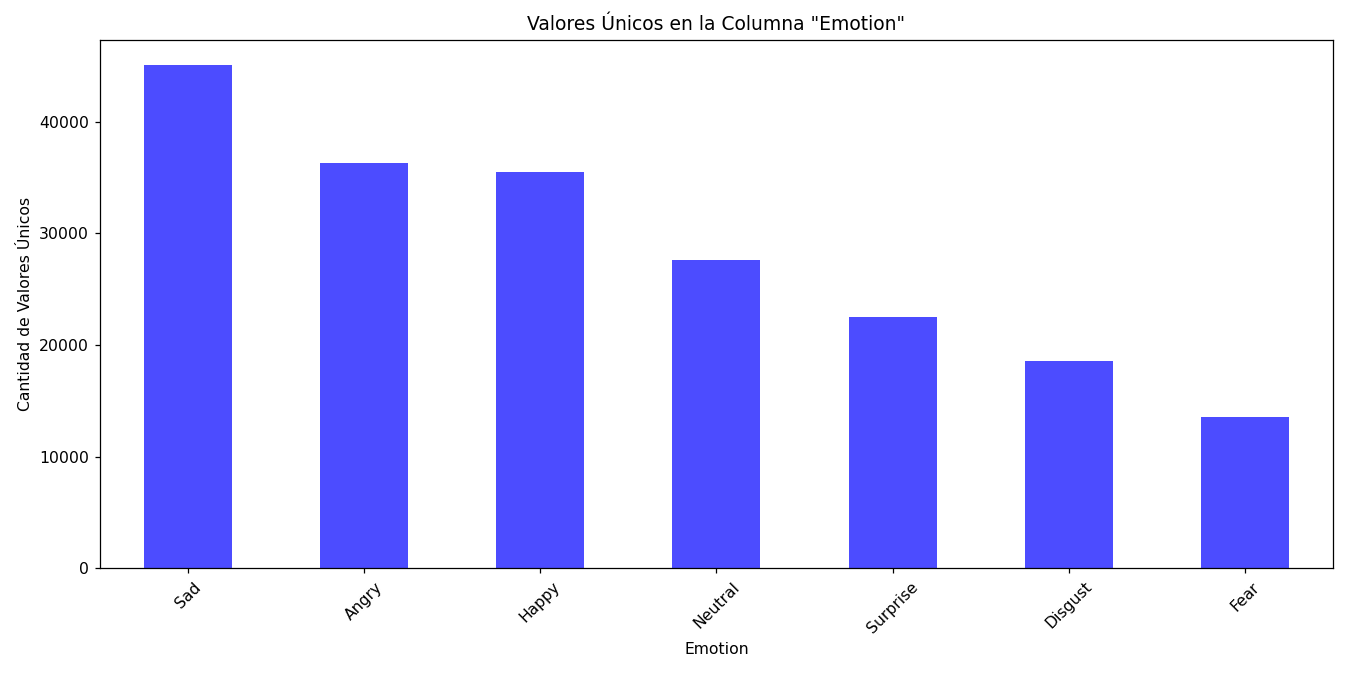

In [29]:
import matplotlib.pyplot as plt
import pandas as pd


# Calcula el número de valores únicos en la columna "Emotion"
emotion_countss = union_valid_df['Emotion'].value_counts()

# Habilita la funcionalidad de zoom en los gráficos
%matplotlib notebook

# Crea un gráfico de barras para visualizar los valores únicos
plt.figure(figsize=(12, 6))
emotion_countss.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Valores Únicos en la Columna "Emotion"')
plt.xlabel('Emotion')
plt.ylabel('Cantidad de Valores Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# No es necesario ejecutar esta parte pq ya tengo los resultados de la union de la primera ejecución

In [30]:
# # Tipo de datos a procesar (validación)
# kind = "Valid"

# # Itera a través de las filas (utensilios) en el DataFrame 'validaudio'
# for sel in tqdm(union_valid_df.itertuples(), total=len(union_valid_df)):
    
#     # Construye la ruta al archivo de recorte (crop) correspondiente
#     croppath = sel.Filepath_y
    
#     # Busca todos los archivos de recorte que coincidan con la ruta
# #     crops = glob(croppath)
    
#     # Si no hay recortes disponibles para este diálogo y frase, continúa con la siguiente iteración
# #     if len(crops) == 0:
# #         continue
    
#     # Etiqueta de emoción del hablante
#     label = sel.Emotion
    
#     # Índice de la etiqueta en 'labelnames' (diccionario de etiquetas)
#     ilabel = labeldict[label]
    
#     # Ruta al archivo de audio correspondiente a este diálogo y frase
#     audiopath = sel.Filepath_x
    
#     # Duración del audio obtenida con librosa
#     audio_duration = sel.Duration
    
#     # Texto (utterance) asociado al hablante
#     texts = sel.Lemmatized_Tokens
    
#     # Crea un DataFrame con la información recopilada
#     rowdf = pd.DataFrame({
#         "filename": audiopath,
#         "impath": croppath,
#         "AudioDuration": audio_duration,
#         "label": label,
#         "Text": texts, 
#         "ilabel": ilabel,
#     }, index=pd.Index([0]))

#     # Concatena el DataFrame 'rowdf' al DataFrame 'validdf'
#     validdf = pd.concat([validdf, rowdf], ignore_index=True)
# # Guarda el DataFrame 'validdf' en un archivo CSV
# validdf.to_csv(val_csv, sep='|', float_format='%.3f') 

# Acá ocupo lo de arriba y me ahorro tiempo

In [31]:
validdf = pd.read_csv(val_csv, sep='|', index_col='Unnamed: 0')
validdf

filename                                             impath  \
0           NaN  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...   
1           NaN  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...   
2           NaN  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...   
3           NaN  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...   
4           NaN  D:\Datasets\MERDWild\Test\Imagenes\00019\frame...   
...         ...                                                ...   
199161      NaN  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...   
199162      NaN  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...   
199163      NaN  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...   
199164      NaN  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...   
199165      NaN  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...   

        AudioDuration    label  ilabel Text  
0                1.84  Neutral       0  NaN  
1                1.84  Neutral       0  NaN  
2                1.84  Neutral       0  NaN  
3                1.84  Neutral       0  NaN  
4                1.84  Neutral       0  NaN  
...               ...      ...     ...  ...  
199161            NaN      Sad       5  NaN  
199162            NaN      Sad       5  NaN  
199163            NaN      Sad       5  NaN  
199164            NaN      Sad       5  NaN  
199165            NaN      Sad       5  NaN  

[199166 rows x 6 columns]

In [32]:
#union_valid_df.columns

In [33]:
# import matplotlib.pyplot as plt
# import pandas as pd

# null_counts_valid = union_valid_df.isnull().sum()

# %matplotlib notebook

# # Crea un gráfico de barras para visualizar los valores nulos
# plt.figure(figsize=(39, 6))
# null_counts_valid.plot(kind='bar')
# plt.title('Valores Nulos por Columna')
# plt.xlabel('Columna')
# plt.ylabel('Cantidad de Valores Nulos')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [34]:
#print(null_counts_valid)

### leer Dataset

In [35]:
def load_set(path):
    return pd.read_csv(path, sep='|')

#traindf = load_set(train_csv)
validdf = load_set(val_csv)


print(f"Tenemos {len(traindf)} eventos en entrenamiento y {len(validdf)} de validacion")

Tenemos 460920 eventos en entrenamiento y 199166 de validacion


In [36]:
validdf

Unnamed: 0 filename  \
0                0      NaN   
1                1      NaN   
2                2      NaN   
3                3      NaN   
4                4      NaN   
...            ...      ...   
199161      199161      NaN   
199162      199162      NaN   
199163      199163      NaN   
199164      199164      NaN   
199165      199165      NaN   

                                                   impath  AudioDuration  \
0       D:\Datasets\MERDWild\Test\Imagenes\00019\frame...           1.84   
1       D:\Datasets\MERDWild\Test\Imagenes\00019\frame...           1.84   
2       D:\Datasets\MERDWild\Test\Imagenes\00019\frame...           1.84   
3       D:\Datasets\MERDWild\Test\Imagenes\00019\frame...           1.84   
4       D:\Datasets\MERDWild\Test\Imagenes\00019\frame...           1.84   
...                                                   ...            ...   
199161  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...            NaN   
199162  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...            NaN   
199163  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...            NaN   
199164  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...            NaN   
199165  D:\Datasets\MERDWild\Test\Imagenes\20066\frame...            NaN   

          label  ilabel Text  
0       Neutral       0  NaN  
1       Neutral       0  NaN  
2       Neutral       0  NaN  
3       Neutral       0  NaN  
4       Neutral       0  NaN  
...         ...     ...  ...  
199161      Sad       5  NaN  
199162      Sad       5  NaN  
199163      Sad       5  NaN  
199164      Sad       5  NaN  
199165      Sad       5  NaN  

[199166 rows x 7 columns]

In [37]:
#sel = traindf.sample(1).squeeze()
traindf.head(2)

filename  \
0  D:\Datasets\MERDWild\Test\Audios\00024.wav   
1  D:\Datasets\MERDWild\Test\Audios\00024.wav   

                                              impath  AudioDuration  label  \
0  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16  Happy   
1  D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16  Happy   

   ilabel                      Text  
0       4  ['idiom', 'make', 'sin']  
1       4  ['idiom', 'make', 'sin']

### Features de Imagenes

In [55]:
def readimages(path):
    image = imread(path)
    if len(image.shape) == 2:
        image = gray2rgb(image)
    image = img_as_float32(image)
    image = resize_local_mean(image, (48, 48))
    return image.transpose((2, 0, 1))

def imsamples(imagepaths, batchsize=16):
    images = np.stack([readimages(path) for path in imagepaths], axis=0)
    n_steps = (len(images) // batchsize) + 1
    iterator = np.array_split(images, n_steps)
    for it in iterator:
        yield torch.from_numpy(it).float()

Como ya tenemos los samples listos de imagen, tenemos que obtener los features, promediarlos y guardarlos, asignado a su evento

In [56]:
#VGG19
cfg = {
	'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
	'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
	'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
	'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class ShortVGG(nn.Module):
	def __init__(self, vgg_name='VGG19', numclasses=8, pretrain=False):
		super(ShortVGG, self).__init__()
		self.Name = vgg_name
		self.features = self._make_layers(cfg[vgg_name])
		self.avgpool = nn.AvgPool2d(kernel_size=1, stride=1)
		self.classifier = nn.Linear(512, numclasses)
		if pretrain:
			self.load_pretrain()

	def forward(self, x):
		out = self.features(x)
		out = self.avgpool(out)
		out = out.view(out.size(0), -1)
		out = F.dropout(out, p=0.5, training=self.training)
		out = self.classifier(out)
		return out

	def _make_layers(self, cfg):
		layers = []
		in_channels = 3
		for x in cfg:
			if x == 'M':
				layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
			else:
				layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
									nn.BatchNorm2d(x),
									nn.ReLU(inplace=True)]
				in_channels = x
		
		return nn.Sequential(*layers)

In [57]:
model = torch.load(solo_img_pth)
model.to('cuda').eval()

ShortVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [58]:
traindf

filename  \
0       D:\Datasets\MERDWild\Test\Audios\00024.wav   
1       D:\Datasets\MERDWild\Test\Audios\00024.wav   
2       D:\Datasets\MERDWild\Test\Audios\00024.wav   
3       D:\Datasets\MERDWild\Test\Audios\00024.wav   
4       D:\Datasets\MERDWild\Test\Audios\00024.wav   
...                                            ...   
460915                                         NaN   
460916                                         NaN   
460917                                         NaN   
460918                                         NaN   
460919                                         NaN   

                                                   impath  AudioDuration  \
0       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
1       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
2       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
3       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
4       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
...                                                   ...            ...   
460915  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460916  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460917  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460918  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460919  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   

        label  ilabel                      Text  
0       Happy       4  ['idiom', 'make', 'sin']  
1       Happy       4  ['idiom', 'make', 'sin']  
2       Happy       4  ['idiom', 'make', 'sin']  
3       Happy       4  ['idiom', 'make', 'sin']  
4       Happy       4  ['idiom', 'make', 'sin']  
...       ...     ...                       ...  
460915    Sad       5                       NaN  
460916    Sad       5                       NaN  
460917    Sad       5                       NaN  
460918    Sad       5                       NaN  
460919    Sad       5                       NaN  

[460920 rows x 6 columns]

In [59]:
allpreds = dict()

# num_filas = len(traindf)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_image = traindf.drop_duplicates(subset=['impath']).copy()

# num_filas = len(traindf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_image = traindf_image.dropna(subset=['impath']).copy()

# num_filas = len(traindf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

processed_impath = set()

for sel in tqdm(traindf.itertuples(), total=len(traindf)):
    if isinstance(sel.impath, str):
        if sel.filename not in processed_impath:
            processed_impath.add(sel.impath)
            images = glob(sel.impath)
            images.sort()
            if len(images) == 0 or not os.path.exists(str(sel.filename)):
                continue
            preds = list()

            for sample in imsamples(images):
                data = sample.to("cuda")
                pred = model(data)
                detached_pred = pred.detach().cpu().numpy()
                preds.append(detached_pred) 
            preds = np.concatenate(preds, axis=0).mean(axis=0)
            preds = np.expand_dims(preds, 0) 
            allpreds[sel.Index] = softmax(preds)
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

100%|███████████████████████████████████████████████████████████████████████| 460920/460920 [1:07:55<00:00, 113.08it/s]


In [60]:
with open(train_img, "wb") as file:
    pickle.dump(allpreds, file)

In [61]:
allpreds = dict()

# num_filas = len(validdf)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_image = validdf.drop_duplicates(subset=['impath']).copy()

# num_filas = len(validdf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_image = validdf_image.dropna(subset=['impath']).copy()

# num_filas = len(validdf_image)

# print(f"El DataFrame tiene {num_filas} filas.")


processed_impath = set()

for sel in tqdm(validdf.itertuples(), total=len(validdf)):
    if isinstance(sel.impath, str):
        if sel.filename not in processed_impath:
            processed_impath.add(sel.impath)
            images = glob(sel.impath)
            images.sort()
            if len(images) == 0:
                continue
            if isinstance(sel.filename, str):
                if not os.path.exists(sel.filename):
                    continue
                preds = list()
                for sample in imsamples(images):
                    data = sample.to("cuda")
                    pred = model(data) 
                    detached_pred = pred.detach().cpu().numpy() 
                    preds.append(detached_pred) 
                preds = np.concatenate(preds, axis=0).mean(axis=0)
                preds = np.expand_dims(preds, 0) 
                allpreds[sel.Index] = softmax(preds)
            else:
                allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

100%|█████████████████████████████████████████████████████████████████████████| 199166/199166 [28:45<00:00, 115.40it/s]


In [62]:
print(allpreds[100])

[[3.6756043e-11 1.9484673e-08 7.6706733e-08 9.9999964e-01 2.4389475e-08
  2.9608014e-08 2.3493691e-07]]


In [63]:
with open(valid_img, "wb") as file:
    pickle.dump(allpreds, file)

In [64]:
torch.cuda.empty_cache()

del(model)
print("Eliminado")

Eliminado


### Features de Audio

In [65]:
def get_spect(path, duration):
    wav, sr = librosa.load(path, sr=22400, duration=np.minimum(duration, 7))
    if duration >= 7:
        wav = librosa.util.pad_center(data=wav, size=22400*7, mode="constant")
    spect = librosa.feature.melspectrogram(
        y=wav,
        sr=22400,
        n_fft=1024,
        hop_length=(22400*7)//255, 
        n_mels=256,
    )
    spect_db = librosa.power_to_db(spect, ref=np.max, top_db=80)

    norm_spect = colormaps["jet"](Normalize()(spect_db))

    spectrogram = np.transpose(norm_spect[...,:-1], (2,0,1))

    return torch.from_numpy(np.expand_dims(spectrogram, 0)).float()

Importamos el modelo

In [66]:
model = torch.load(solo_audios_pth)
model.to('cuda').eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [67]:
import math
allpreds = dict()

# mask = traindf['AudioDuration'].isna()

# df_with_nan_duration = traindf[mask]

# num_filas = len(traindf)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_audio = traindf.drop_duplicates(subset=['filename']).copy()

# num_filas = len(traindf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_audio = traindf_audio.dropna(subset=['filename']).copy()

# num_filas = len(traindf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")

processed_filenames = set()

for sel in tqdm(traindf.itertuples()):
    if isinstance(sel.filename, str) and not math.isnan(sel.AudioDuration):
        if sel.filename not in processed_filenames:
            processed_filenames.add(sel.filename)

            spectrogram = get_spect(sel.filename, sel.AudioDuration)
            video_id, _ = os.path.splitext(os.path.basename(sel.filename))

            data = spectrogram.to("cuda")

            pred = model(data)
            detached_pred = pred.detach().cpu().numpy()

            allpreds[sel.Index] = softmax(detached_pred)
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

with open(train_audios, "wb") as file:
    pickle.dump(allpreds, file)

460920it [02:11, 3505.40it/s]


In [51]:
# import pickle
# from tqdm import tqdm
# import math
# allpreds = dict()

# # mask = validdf['AudioDuration'].isna()

# # df_with_nan_duration = validdf[mask]


# for sel in tqdm(validdf.itertuples()):
#     if isinstance(sel.filename, str):
#         #print(type(sel.AudioDuration))
#         #print(sel.AudioDuration)
#         if not math.isnan(sel.AudioDuration):
#             #print(sel.AudioDuration)
#             spectrogram = get_spect(sel.filename, sel.AudioDuration)
#             #print(spectrogram)       
#             if spectrogram is not None:
#                 video_id, _ = os.path.splitext(os.path.basename(sel.filename))
#                 data = spectrogram.to("cuda")
#                 pred = model(data)
#                 detached_pred = pred.detach().cpu().numpy()
#                 #print(spectrogram)
#                 allpreds[sel.Index] = softmax(detached_pred)  # Aplica la función softmax a las predicciones

# with open(valid_audios, "wb") as file:
#     pickle.dump(allpreds, file)

In [68]:
import pickle
from tqdm import tqdm
import math
allpreds = dict()


# mask = validdf['AudioDuration'].isna()

# df_with_nan_duration = validdf[mask]

# num_filas = len(validdf)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_audio = validdf.drop_duplicates(subset=['filename']).copy()

# num_filas = len(validdf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_audio = validdf_audio.dropna(subset=['filename']).copy()

# num_filas = len(validdf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")
processed_filenames = set()

for sel in tqdm(validdf.itertuples()):
    if isinstance(sel.filename, str) and not math.isnan(sel.AudioDuration):
        if sel.filename not in processed_filenames:
            processed_filenames.add(sel.filename)
            spectrogram = get_spect(sel.filename, sel.AudioDuration)
            video_id, _ = os.path.splitext(os.path.basename(sel.filename))
            data = spectrogram.to("cuda")
            pred = model(data)
            detached_pred = pred.detach().cpu().numpy()
            allpreds[sel.Index] = softmax(detached_pred)  # Aplica la función softmax a las predicciones
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

with open(valid_audios, "wb") as file:
    pickle.dump(allpreds, file)

199166it [00:57, 3465.94it/s]


In [69]:
print(allpreds[100])

[0. 0. 0. 0. 0. 0. 0.]


In [70]:
torch.cuda.empty_cache()

del(model)

In [71]:
traindf

filename  \
0       D:\Datasets\MERDWild\Test\Audios\00024.wav   
1       D:\Datasets\MERDWild\Test\Audios\00024.wav   
2       D:\Datasets\MERDWild\Test\Audios\00024.wav   
3       D:\Datasets\MERDWild\Test\Audios\00024.wav   
4       D:\Datasets\MERDWild\Test\Audios\00024.wav   
...                                            ...   
460915                                         NaN   
460916                                         NaN   
460917                                         NaN   
460918                                         NaN   
460919                                         NaN   

                                                   impath  AudioDuration  \
0       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
1       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
2       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
3       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
4       D:\Datasets\MERDWild\Test\Imagenes\00024\frame...           2.16   
...                                                   ...            ...   
460915  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460916  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460917  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460918  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   
460919  D:\Datasets\MERDWild\Test\Imagenes\15598\frame...            NaN   

        label  ilabel                      Text  
0       Happy       4  ['idiom', 'make', 'sin']  
1       Happy       4  ['idiom', 'make', 'sin']  
2       Happy       4  ['idiom', 'make', 'sin']  
3       Happy       4  ['idiom', 'make', 'sin']  
4       Happy       4  ['idiom', 'make', 'sin']  
...       ...     ...                       ...  
460915    Sad       5                       NaN  
460916    Sad       5                       NaN  
460917    Sad       5                       NaN  
460918    Sad       5                       NaN  
460919    Sad       5                       NaN  

[460920 rows x 6 columns]

### Features de Texto

In [73]:
bertmodels = 'bert-large-nli-stsb-mean-tokens'
model = SentenceTransformer(bertmodels)

traindf['Text'] = traindf['Text'].astype(str)
validdf['Text'] = validdf['Text'].astype(str)

# traindf_text = traindf.drop_duplicates(subset=['filename', 'Text']).copy()
# validdf_text = validdf.drop_duplicates(subset=['filename', 'Text']).copy()
# print("Cantidad de datos en traindf unicos:", len(traindf_text))
# print("Cantidad de datos en validdf unicos:", len(validdf_text))


train_embed = model.encode(traindf.Text.to_list()) 
valid_embed = model.encode(validdf.Text.to_list()) 

# Clasificador - MLP (Perceptrón Multicapa)
clf = MLPClassifier(
    hidden_layer_sizes=(500, 300,),
    learning_rate_init=1e-4, 
    tol=1e-6, 
    early_stopping=True,  
    verbose=True, 
)

clf.fit(train_embed, traindf.ilabel.tolist())

Iteration 1, loss = 0.70751844
Validation score: 0.866072
Iteration 2, loss = 0.37284457
Validation score: 0.869804
Iteration 3, loss = 0.35925440
Validation score: 0.870563
Iteration 4, loss = 0.35453899
Validation score: 0.869609
Iteration 5, loss = 0.35129597
Validation score: 0.866116
Iteration 6, loss = 0.34906186
Validation score: 0.868828
Iteration 7, loss = 0.34735843
Validation score: 0.871106
Iteration 8, loss = 0.34590845
Validation score: 0.871236
Iteration 9, loss = 0.34447016
Validation score: 0.871453
Iteration 10, loss = 0.34333666
Validation score: 0.871084
Iteration 11, loss = 0.34249726
Validation score: 0.871995
Iteration 12, loss = 0.34166145
Validation score: 0.872039
Iteration 13, loss = 0.34083446
Validation score: 0.872364
Iteration 14, loss = 0.33994768
Validation score: 0.872255
Iteration 15, loss = 0.33940653
Validation score: 0.871995
Iteration 16, loss = 0.33893187
Validation score: 0.872993
Iteration 17, loss = 0.33839000
Validation score: 0.872039
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(500, 300),
              learning_rate_init=0.0001, tol=1e-06, verbose=True)

In [74]:
train_preds = clf.predict_proba(train_embed)
valid_preds = clf.predict_proba(valid_embed)

train_pkls = {ix: p for ix, p in zip(traindf.index, train_preds)}
valid_pkls = {ix: p for ix, p in zip(traindf.index, valid_preds)}  

print(train_pkls[0])

[9.1503355e-10 1.2249533e-04 5.2330784e-15 1.9594951e-07 9.9986362e-01
 1.3705794e-05 2.6798798e-08]


In [75]:
with open(train_text, "wb") as file:
    pickle.dump(train_pkls, file)

with open(valid_text, "wb") as file:
    pickle.dump(valid_pkls, file)

## EmbraceNet

In [76]:
class WeightedSum(nn.Module):
    def __init__(self, number_modals, outchannels, probabilities=None,
                                trainable=False, mode='', device=torch.device('cpu')):
        super(WeightedSum, self).__init__()
        self.NumberModalities = number_modals
        self.Mode = mode
        self.Probabilities = probabilities
        self.Device = device
        self.set_weights(outchannels, trainable)

    def set_weights(self, outchannels, trainable):
        i = 0
        if self.Mode == 'convs':
            setattr(self, 'Weight_%d' % (i), nn.Conv1d(self.NumberModalities, outchannels, kernel_size=1, stride=1))
            if not trainable:
                getattr(self, 'Weight_%d' % (i)).weight.requires_grad = False

        elif self.Mode == 'tensor':
            if self.Probabilities is not None:
                tt = torch.tensor(self.Probabilities, dtype=torch.float)
            else:
                tt = torch.ones(self.NumberModalities, outchannels, dtype=torch.float)
            tt = torch.div(tt, torch.sum(tt, dim=0, keepdim=True)).to(self.Device)
            self.Weight_1 = nn.Parameter(tt, requires_grad=trainable)
        else:
            raise NameError('{} is not supported yet'.format(self.Mode))

    def forward(self, outs, availability):
        b, c, n = outs.shape
        W = getattr(self, 'Weight_%d' % (1))
        if self.Mode == 'convs':
            out = W(outs)
        elif self.Mode == 'tensor':
            W = torch.stack([W] * b).view(b, c)
            W = torch.mul(W, availability)
            W = torch.div(W, torch.sum(W, dim=-1, keepdim=True)).view(b, c, 1)
            out = torch.zeros(b, 1, n, dtype=torch.float, device=self.Device)
            for i, o in enumerate(outs):
                out[i, :, :] = (torch.mm(o.T, W[i].float())).T

        return out.view(out.shape[0], out.shape[-1])

In [77]:
# Embracenet
class EmbraceNet(nn.Module):
    def __init__(self, input_size_list=[], embracement_size=32, docker_arch=[], device=torch.device('cpu')):
        super(EmbraceNet, self).__init__()
        self.input_size_list = input_size_list
        self.embracement_size = embracement_size
        self.bypass_docking = self.set_dockers(docker_arch)
        self.Device = device

    def set_dockers(self, docker_architecture=[]):
        bypass = True
        for i, arch in enumerate(docker_architecture):
            bypass = False
            layers = []
            inC = self.input_size_list[i]
            for l in arch:
                if l == 'D':
                    layers += [nn.Dropout()]
                elif l == 'R':
                    layers += [nn.ReLU()]
                else:
                    layers += [nn.Linear(inC, l)]
                    inC = l
            setattr(self, 'docking_%d' % (i), nn.Sequential(*layers))
        return bypass

    def forward(self, input_list, availabilities=None, selection_probabilities=None):
        assert len(input_list) == len(self.input_size_list)
        num_modalities = len(input_list)
        batch_size = input_list[0].shape[0]
        docking_output_list = []
        if self.bypass_docking:
            docking_output_list = input_list
        else:
            for i, input_data in enumerate(input_list):
                x = getattr(self, 'docking_%d' % (i))(input_data)
                x = nn.functional.relu(x)
                docking_output_list.append(x)

        if availabilities is None:
            availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.Device)
        else:
            availabilities = availabilities.float().to(self.Device)

        if selection_probabilities is None:
            selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.Device)
        else:
            selection_probabilities = selection_probabilities.float().to(self.Device)

        selection_probabilities = torch.mul(selection_probabilities, availabilities)
        probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
        selection_probabilities = torch.div(selection_probabilities, probability_sum)

        docking_output_stack = torch.stack(docking_output_list, dim=-1)

        modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)
        modality_toggles = nn.functional.one_hot(modality_indices, num_classes=num_modalities).float()

        embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
        embracement_output = torch.sum(embracement_output_stack, dim=-1)

        return embracement_output

In [78]:
class ModelNewFour(nn.Module):
    def __init__(self, num_classes, input_sizes, final_input_sizes,
                 embrace2_param, embrace3_param, wsum_confg,
                 device, trainable_probs, useffinal, use_ws,
                 use_ll, ll_configs):
        super(ModelNewFour, self).__init__()

        self.NClasses = num_classes
        self.InputSize = input_sizes
        self.FinalInputSize = final_input_sizes
        self.Device = device

        self.EmbNet2 = EmbraceNet(**embrace2_param)
        self.EmbNet3 = EmbraceNet(**embrace3_param)
        self.WeightedSum = WeightedSum(**wsum_confg)

        self.UseLL1 = use_ll[0]
        self.UseLL2 = use_ll[1]
        self.UseLL3 = use_ll[2]
        self.UseFinalsInFinal = useffinal
        self.UseWSum = use_ws
        self.TrainableProbs = trainable_probs

        self.initProbabilities()

        if self.UseLL1:
            self.LL1 = self.gen_ll(**ll_configs[0])
        if self.UseLL2:
            self.LL2 = self.gen_ll(**ll_configs[1])
        if self.UseLL3:
            self.LL3 = self.gen_ll(**ll_configs[2])

    def gen_ll(self, config, embrace_size):
        layers = []
        inC = embrace_size
        for x in config:
            if x == 'D':
                layers += [nn.Dropout()]
            elif x == 'R':
                layers += [nn.ReLU()]
            else:
                layers += [nn.Linear(inC, x)]
                inC = x
        return nn.Sequential(*layers)

    def initProbabilities(self):
        p1 = torch.ones(1, self.InputSize, dtype=torch.float)
        p2 = torch.ones(1, self.InputSize, dtype=torch.float)
        p3 = torch.ones(1, self.FinalInputSize, dtype=torch.float)
        self.p1 = torch.div(p1, torch.sum(p1, dim=-1, keepdim=True)).to(self.Device)
        self.p2 = torch.div(p2, torch.sum(p2, dim=-1, keepdim=True)).to(self.Device)
        self.p3 = torch.div(p3, torch.sum(p3, dim=-1, keepdim=True)).to(self.Device)

        self.P1 = nn.Parameter(p1, requires_grad=self.TrainableProbs)
        self.P2 = nn.Parameter(p2, requires_grad=self.TrainableProbs)
        self.P3 = nn.Parameter(p3, requires_grad=self.TrainableProbs)

    def forward(self, outputs2, available):
        batch_size = outputs2[0].shape[0]
        availabilities = torch.ones(batch_size, self.FinalInputSize, dtype=torch.float, device=self.Device)

        probabilities2 = torch.stack([self.p2] * batch_size, dim=0).view(batch_size, self.InputSize)
        out2 = self.EmbNet2.forward(outputs2, available, probabilities2)
        if self.UseLL2:
            out2 = self.LL2(out2)

        wsout = self.WeightedSum.forward(torch.stack(outputs2, dim=1), available)
        concat = torch.cat(outputs2, dim=-1)

        probabilities3 = torch.stack([self.p3] * batch_size, dim=0).view(batch_size, self.FinalInputSize)

        if not self.UseFinalsInFinal:
            availabilities[:, -1] = 0.0
        if not self.UseWSum:
            availabilities[:, -2] = 0.0

        out = self.EmbNet3.forward([out2, wsout, concat], availabilities, probabilities3)

        if self.UseLL3:
            out = self.LL3(out)

        return out

In [79]:
ABLATIONS = ["IAT","IXX","XAX","XXT", "IAX", "IXT", "XAT"]
print(ABLATIONS)

['IAT', 'IXX', 'XAX', 'XXT', 'IAX', 'IXT', 'XAT']


### DatasetEmbNet

In [80]:
class DatasetEmbNet(Dataset):
    def __init__(self, csvfile, featroot="", kind='train', ablation="XXX", transform=None):
        super(DatasetEmbNet, self).__init__()

        self.transform = transform
        self.modalities = ["image", "audio", "text"]

        df = pd.read_csv(csvfile, sep='|')
        df = df[df['label'] != "Other"]

        self.features = {t: self.load_pickledict(os.path.join(featroot, f"{kind}_{t}_feats.pkl")) for t in self.modalities }
        self.ablation = ablation
        indexes = reduce(np.intersect1d, [list(self.features[mod].keys()) for mod in self.modalities])
        self.dataframe = df.loc[pd.Index(indexes)]
        
        df
    def load_pickledict(self, path):
        with open(path, "rb") as file:
            data = pickle.load(file)
        return data

    def ablate(self, index):
        outdata = dict()
        jointprob = np.zeros((3,))
        for n, k in enumerate(self.ablation):
            if k == "X":
                # Si no hay datos para esta modalidad, se crea un arreglo de ceros.
                outdata[self.modalities[n]] = np.zeros((7,), dtype=np.float32)
                continue
            elif k == "I":
                # Si la modalidad es imagen, se obtienen las características de imagen.
                outdata[self.modalities[n]] = self.features["image"][index].squeeze()
            elif k == "A":
                # Si la modalidad es audio, se obtienen las características de audio.
                outdata[self.modalities[n]] = self.features["audio"][index].squeeze()
            elif k == "T":
                # Si la modalidad es texto, se obtienen las características de texto.
                outdata[self.modalities[n]] = self.features["text"][index]
            else:
                raise ValueError("Esto no debería pasar")
            jointprob[n] = 1.
        
        # Registra la disponibilidad de las modalidades en el diccionario de datos.
        outdata["availables"] = jointprob
        return outdata

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.to_list()

        sam = self.dataframe.iloc[index]
        
        sample = self.ablate(sam["Unnamed: 0"])

        sample["label"] = np.array([sam.ilabel])

        if self.transform:
            sample = self.transform(sample)
        return sample

In [81]:
class FusionTransformer(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        return {key:torch.from_numpy(val) for key,val in sample.items()}

### Entrenamiento

In [82]:
config = {
    "num_classes": 7, 
    "input_sizes": 3,
    "final_input_sizes": 3,

    "embrace2_param": {
        "input_size_list": [7, 7, 7], 
        "embracement_size": 16, 
        "docker_arch": [[32, "D", 16], [32, "D", 16], [32, "D", 16]],
        "device": torch.device('cpu')
    },

    "embrace3_param": {
        "input_size_list": [16, 7, 21], 
        "embracement_size": 16,
        "docker_arch": [[16], [16], [16]],
        "device": torch.device('cpu') 
    },

    "wsum_confg": {
        "number_modals": 3, 
        "outchannels": 1, 
        "probabilities": None, 
        "trainable": False, 
        "mode": "tensor", 
        "device": torch.device('cpu')
    },

    "device": torch.device('cpu'), 
    "trainable_probs": False,  
    "useffinal": True, 
    "use_ws": True,  

    "use_ll": [False, False, True],  

    "ll_configs": [{}, {}, {"config": [7, "R"], "embrace_size": 16}]
}

Experimento IAT
395518
170538



Train [1/20]:   0%|                                                              | 1/24720 [00:59<411:17:23, 59.90s/it]

Train [1/20]:   0%|▏                             | 120/24720 [00:01<03:47, 108.20it/s, Loss=1.8482 - Accuracy = 0.0010]


Train [1/20]:   1%|▎                             | 242/24720 [00:02<03:47, 107.40it/s, Loss=1.8463 - Accuracy = 0.0021]


Train [1/20]:   1%|▍                             | 363/24720 [00:03<03:42, 109.24it/s, Loss=1.9473 - Accuracy = 0.0031]


Train [1/20]:   2%|▌                             | 484/24720 [00:04<03:42, 108.92it/s, Loss=1.9473 - Accuracy = 0.0042]


Train [1/20]:   2%|▋                             | 605/24720 [00:05<03:44, 107.44it/s, Loss=1.9520 - Accuracy = 0.0053]


Train [1/20]:   3%|▉                             | 727/24720 [00:06<03:41, 108.38it/s, Loss=1.8499 - Accuracy = 0.0065]


Train [1/20]:   3%|█                             | 848/24720 [00:07<03:57, 100.48it/s, Loss=1.8418 - Accuracy = 0.0079]


Train [1/20]:   4%|█▏                             | 968/24720 [00:09<04:12, 93.95it/s, Loss=1.9211 - Accuracy = 0.0094]


Train [1/20]:   4%|█▎                            | 1088/24720 [00:10<04:06, 95.90it/s, Loss=1.9753 - Accuracy = 0.0108]


Train [1/20]:   5%|█▍                            | 1208/24720 [00:11<04:05, 95.77it/s, Loss=1.8464 - Accuracy = 0.0125]


Train [1/20]:   5%|█▌                           | 1329/24720 [00:13<03:50, 101.68it/s, Loss=1.8851 - Accuracy = 0.0142]


Train [1/20]:   6%|█▊                            | 1449/24720 [00:14<03:57, 97.93it/s, Loss=1.7969 - Accuracy = 0.0160]


Train [1/20]:   6%|█▊                           | 1570/24720 [00:15<03:36, 106.90it/s, Loss=1.8310 - Accuracy = 0.0179]


Train [1/20]:   7%|██                            | 1691/24720 [00:16<03:53, 98.51it/s, Loss=1.7703 - Accuracy = 0.0199]


Train [1/20]:   7%|██▏                           | 1812/24720 [00:17<03:49, 99.83it/s, Loss=1.8514 - Accuracy = 0.0219]


Train [1/20]:   8%|██▎                           | 1932/24720 [00:19<03:56, 96.23it/s, Loss=1.7079 - Accuracy = 0.0240]


Train [1/20]:   8%|██▍                          | 2052/24720 [00:20<03:45, 100.69it/s, Loss=1.7479 - Accuracy = 0.0262]


Train [1/20]:   9%|██▋                           | 2173/24720 [00:21<03:48, 98.80it/s, Loss=1.8221 - Accuracy = 0.0283]


Train [1/20]:   9%|██▋                          | 2294/24720 [00:22<03:35, 104.19it/s, Loss=1.6674 - Accuracy = 0.0306]


Train [1/20]:  10%|██▊                          | 2415/24720 [00:23<03:35, 103.73it/s, Loss=1.5265 - Accuracy = 0.0329]


Train [1/20]:  10%|██▉                          | 2536/24720 [00:24<03:21, 109.88it/s, Loss=1.7079 - Accuracy = 0.0352]


Train [1/20]:  11%|███                          | 2658/24720 [00:26<03:19, 110.42it/s, Loss=1.5187 - Accuracy = 0.0375]


Train [1/20]:  11%|███▎                         | 2780/24720 [00:27<03:20, 109.41it/s, Loss=1.7529 - Accuracy = 0.0398]


Train [1/20]:  12%|███▍                         | 2902/24720 [00:28<03:16, 111.29it/s, Loss=1.7159 - Accuracy = 0.0423]


Train [1/20]:  12%|███▌                         | 3024/24720 [00:29<03:15, 110.93it/s, Loss=1.5555 - Accuracy = 0.0447]


Train [1/20]:  13%|███▋                         | 3145/24720 [00:30<03:18, 108.45it/s, Loss=1.7164 - Accuracy = 0.0471]


Train [1/20]:  13%|███▊                         | 3267/24720 [00:31<03:14, 110.30it/s, Loss=1.1737 - Accuracy = 0.0495]


Train [1/20]:  14%|███▉                         | 3389/24720 [00:32<03:10, 111.94it/s, Loss=1.6465 - Accuracy = 0.0519]


Train [1/20]:  14%|████                         | 3511/24720 [00:33<03:17, 107.25it/s, Loss=1.4792 - Accuracy = 0.0543]


Train [1/20]:  15%|████▎                        | 3633/24720 [00:34<03:09, 111.50it/s, Loss=1.5373 - Accuracy = 0.0568]


Train [1/20]:  15%|████▍                        | 3754/24720 [00:35<03:08, 111.41it/s, Loss=1.6911 - Accuracy = 0.0591]


Train [1/20]:  16%|████▌                        | 3876/24720 [00:37<03:10, 109.58it/s, Loss=1.3889 - Accuracy = 0.0615]


Train [1/20]:  16%|████▋                        | 3998/24720 [00:38<03:04, 112.30it/s, Loss=1.5818 - Accuracy = 0.0640]


Train [1/20]:  17%|████▊                        | 4120/24720 [00:39<03:09, 108.87it/s, Loss=1.1869 - Accuracy = 0.0665]


Train [1/20]:  17%|████▉                        | 4241/24720 [00:40<03:20, 102.24it/s, Loss=1.3034 - Accuracy = 0.0690]


Train [1/20]:  18%|█████                        | 4362/24720 [00:41<03:21, 101.06it/s, Loss=1.3121 - Accuracy = 0.0714]


Train [1/20]:  18%|█████▎                       | 4483/24720 [00:42<03:12, 105.37it/s, Loss=1.6387 - Accuracy = 0.0739]


Train [1/20]:  19%|█████▍                       | 4605/24720 [00:43<03:10, 105.73it/s, Loss=1.2648 - Accuracy = 0.0764]


Train [1/20]:  19%|█████▌                       | 4726/24720 [00:45<02:59, 111.30it/s, Loss=1.1751 - Accuracy = 0.0789]


Train [1/20]:  20%|█████▋                       | 4848/24720 [00:46<03:00, 110.16it/s, Loss=1.2746 - Accuracy = 0.0814]


Train [1/20]:  20%|█████▊                       | 4970/24720 [00:47<02:59, 110.00it/s, Loss=1.1818 - Accuracy = 0.0840]


Train [1/20]:  21%|█████▉                       | 5092/24720 [00:48<02:55, 111.65it/s, Loss=1.2543 - Accuracy = 0.0866]


Train [1/20]:  21%|██████                       | 5213/24720 [00:49<02:58, 109.35it/s, Loss=0.9359 - Accuracy = 0.0891]


Train [1/20]:  22%|██████▎                      | 5335/24720 [00:50<02:54, 110.99it/s, Loss=1.2841 - Accuracy = 0.0916]


Train [1/20]:  22%|██████▍                      | 5456/24720 [00:51<02:50, 113.05it/s, Loss=1.2891 - Accuracy = 0.0941]


Train [1/20]:  23%|██████▌                      | 5578/24720 [00:52<02:54, 109.90it/s, Loss=1.0444 - Accuracy = 0.0966]


Train [1/20]:  23%|██████▋                      | 5700/24720 [00:53<02:50, 111.86it/s, Loss=1.0820 - Accuracy = 0.0991]


Train [1/20]:  24%|██████▊                      | 5822/24720 [00:54<02:51, 110.36it/s, Loss=1.3086 - Accuracy = 0.1016]


Train [1/20]:  24%|██████▉                      | 5944/24720 [00:56<02:49, 110.91it/s, Loss=1.0901 - Accuracy = 0.1042]


Train [1/20]:  25%|███████                      | 6066/24720 [00:57<02:52, 107.91it/s, Loss=1.4337 - Accuracy = 0.1067]


Train [1/20]:  25%|███████▎                     | 6187/24720 [00:58<02:47, 110.93it/s, Loss=1.1831 - Accuracy = 0.1092]


Train [1/20]:  26%|███████▍                     | 6309/24720 [00:59<02:47, 109.74it/s, Loss=0.7498 - Accuracy = 0.1117]


Train [1/20]:  26%|███████▌                     | 6431/24720 [01:00<02:43, 112.07it/s, Loss=1.2547 - Accuracy = 0.1143]


Train [1/20]:  27%|███████▋                     | 6553/24720 [01:01<02:42, 111.66it/s, Loss=0.6035 - Accuracy = 0.1169]


Train [1/20]:  27%|███████▊                     | 6674/24720 [01:02<02:46, 108.52it/s, Loss=1.1318 - Accuracy = 0.1194]


Train [1/20]:  27%|███████▉                     | 6796/24720 [01:03<02:40, 111.37it/s, Loss=1.5057 - Accuracy = 0.1220]


Train [1/20]:  28%|████████                     | 6918/24720 [01:04<02:39, 111.45it/s, Loss=0.9196 - Accuracy = 0.1246]


Train [1/20]:  28%|████████▎                    | 7040/24720 [01:05<02:40, 110.47it/s, Loss=1.1836 - Accuracy = 0.1271]


Train [1/20]:  29%|████████▍                    | 7161/24720 [01:07<02:36, 112.34it/s, Loss=1.1986 - Accuracy = 0.1297]


Train [1/20]:  29%|████████▌                    | 7283/24720 [01:08<02:38, 110.31it/s, Loss=1.4560 - Accuracy = 0.1323]


Train [1/20]:  30%|████████▋                    | 7405/24720 [01:09<02:35, 111.23it/s, Loss=1.0896 - Accuracy = 0.1349]


Train [1/20]:  30%|████████▊                    | 7527/24720 [01:10<02:36, 110.04it/s, Loss=1.3133 - Accuracy = 0.1374]


Train [1/20]:  31%|████████▉                    | 7649/24720 [01:11<02:36, 109.25it/s, Loss=0.8532 - Accuracy = 0.1399]


Train [1/20]:  31%|█████████                    | 7771/24720 [01:12<02:31, 112.05it/s, Loss=0.9418 - Accuracy = 0.1425]


Train [1/20]:  32%|█████████▎                   | 7892/24720 [01:13<02:28, 112.98it/s, Loss=0.9506 - Accuracy = 0.1451]


Train [1/20]:  32%|█████████▍                   | 8014/24720 [01:14<02:32, 109.55it/s, Loss=1.1947 - Accuracy = 0.1477]


Train [1/20]:  33%|█████████▌                   | 8136/24720 [01:15<02:29, 111.26it/s, Loss=1.3531 - Accuracy = 0.1503]


Train [1/20]:  33%|█████████▋                   | 8258/24720 [01:16<02:25, 112.99it/s, Loss=1.3899 - Accuracy = 0.1528]


Train [1/20]:  34%|█████████▊                   | 8380/24720 [01:17<02:26, 111.40it/s, Loss=1.2863 - Accuracy = 0.1554]


Train [1/20]:  34%|█████████▉                   | 8501/24720 [01:19<02:30, 107.76it/s, Loss=1.0371 - Accuracy = 0.1580]


Train [1/20]:  35%|██████████                   | 8623/24720 [01:20<02:24, 111.44it/s, Loss=1.0496 - Accuracy = 0.1605]


Train [1/20]:  35%|██████████▎                  | 8745/24720 [01:21<02:22, 111.84it/s, Loss=1.2760 - Accuracy = 0.1632]


Train [1/20]:  36%|██████████▍                  | 8867/24720 [01:22<02:25, 108.78it/s, Loss=0.5703 - Accuracy = 0.1657]


Train [1/20]:  36%|██████████▌                  | 8989/24720 [01:23<02:20, 112.31it/s, Loss=1.1541 - Accuracy = 0.1684]


Train [1/20]:  37%|██████████▋                  | 9110/24720 [01:24<02:18, 112.82it/s, Loss=1.3013 - Accuracy = 0.1710]


Train [1/20]:  37%|██████████▊                  | 9232/24720 [01:25<02:21, 109.75it/s, Loss=0.8239 - Accuracy = 0.1736]


Train [1/20]:  38%|██████████▉                  | 9354/24720 [01:26<02:24, 106.09it/s, Loss=1.1268 - Accuracy = 0.1763]


Train [1/20]:  38%|███████████                  | 9475/24720 [01:27<02:20, 108.61it/s, Loss=1.1002 - Accuracy = 0.1787]


Train [1/20]:  39%|███████████▎                 | 9597/24720 [01:29<02:18, 109.08it/s, Loss=1.2181 - Accuracy = 0.1814]


Train [1/20]:  39%|███████████▍                 | 9718/24720 [01:30<02:14, 111.83it/s, Loss=1.0002 - Accuracy = 0.1839]


Train [1/20]:  40%|███████████▌                 | 9840/24720 [01:31<02:13, 111.58it/s, Loss=1.0442 - Accuracy = 0.1865]


Train [1/20]:  40%|███████████▋                 | 9962/24720 [01:32<02:13, 110.84it/s, Loss=0.7311 - Accuracy = 0.1890]


Train [1/20]:  41%|███████████▍                | 10084/24720 [01:33<02:10, 111.73it/s, Loss=1.2940 - Accuracy = 0.1915]


Train [1/20]:  41%|███████████▌                | 10206/24720 [01:34<02:12, 109.93it/s, Loss=1.3020 - Accuracy = 0.1940]


Train [1/20]:  42%|███████████▋                | 10328/24720 [01:35<02:11, 109.29it/s, Loss=1.2457 - Accuracy = 0.1968]


Train [1/20]:  42%|███████████▊                | 10449/24720 [01:36<02:08, 110.71it/s, Loss=0.8221 - Accuracy = 0.1993]


Train [1/20]:  43%|███████████▉                | 10571/24720 [01:37<02:07, 111.32it/s, Loss=1.4875 - Accuracy = 0.2019]


Train [1/20]:  43%|████████████                | 10693/24720 [01:38<02:05, 111.96it/s, Loss=1.3782 - Accuracy = 0.2046]


Train [1/20]:  44%|████████████▎               | 10815/24720 [01:40<02:06, 109.76it/s, Loss=1.0613 - Accuracy = 0.2073]


Train [1/20]:  44%|████████████▍               | 10936/24720 [01:41<02:11, 104.91it/s, Loss=0.5111 - Accuracy = 0.2099]


Train [1/20]:  45%|████████████▌               | 11057/24720 [01:42<02:14, 101.89it/s, Loss=1.1646 - Accuracy = 0.2124]


Train [1/20]:  45%|█████████████                | 11178/24720 [01:43<02:17, 98.76it/s, Loss=1.3979 - Accuracy = 0.2150]


Train [1/20]:  46%|████████████▊               | 11299/24720 [01:44<02:13, 100.76it/s, Loss=0.8288 - Accuracy = 0.2177]


Train [1/20]:  46%|████████████▉               | 11420/24720 [01:45<02:11, 100.78it/s, Loss=1.2703 - Accuracy = 0.2203]


Train [1/20]:  47%|█████████████▌               | 11540/24720 [01:47<02:17, 96.03it/s, Loss=1.1833 - Accuracy = 0.2228]


Train [1/20]:  47%|█████████████▋               | 11661/24720 [01:48<02:18, 94.08it/s, Loss=1.0324 - Accuracy = 0.2254]


Train [1/20]:  48%|█████████████▊               | 11781/24720 [01:49<02:21, 91.54it/s, Loss=1.1552 - Accuracy = 0.2280]


Train [1/20]:  48%|█████████████▍              | 11901/24720 [01:51<02:07, 100.76it/s, Loss=1.1719 - Accuracy = 0.2304]


Train [1/20]:  49%|█████████████▌              | 12022/24720 [01:52<01:59, 106.11it/s, Loss=1.0576 - Accuracy = 0.2331]


Train [1/20]:  49%|█████████████▊              | 12143/24720 [01:53<02:04, 101.04it/s, Loss=0.9651 - Accuracy = 0.2357]


Train [1/20]:  50%|█████████████▉              | 12264/24720 [01:54<01:58, 104.81it/s, Loss=1.0459 - Accuracy = 0.2383]


Train [1/20]:  50%|██████████████              | 12385/24720 [01:55<02:02, 100.71it/s, Loss=1.2650 - Accuracy = 0.2408]


Train [1/20]:  51%|██████████████▏             | 12507/24720 [01:56<01:51, 109.76it/s, Loss=1.1217 - Accuracy = 0.2434]


Train [1/20]:  51%|██████████████▎             | 12629/24720 [01:57<01:50, 109.88it/s, Loss=1.2347 - Accuracy = 0.2461]


Train [1/20]:  52%|██████████████▍             | 12750/24720 [01:59<01:48, 110.62it/s, Loss=1.5446 - Accuracy = 0.2487]


Train [1/20]:  52%|██████████████▌             | 12872/24720 [02:00<01:47, 110.53it/s, Loss=1.3020 - Accuracy = 0.2515]


Train [1/20]:  53%|██████████████▋             | 12994/24720 [02:01<01:45, 111.57it/s, Loss=0.8924 - Accuracy = 0.2540]


Train [1/20]:  53%|██████████████▊             | 13116/24720 [02:02<01:42, 112.98it/s, Loss=1.0196 - Accuracy = 0.2567]


Train [1/20]:  54%|██████████████▉             | 13237/24720 [02:03<01:41, 113.14it/s, Loss=1.1072 - Accuracy = 0.2592]


Train [1/20]:  54%|███████████████▏            | 13359/24720 [02:04<01:40, 112.56it/s, Loss=1.4881 - Accuracy = 0.2619]


Train [1/20]:  55%|███████████████▎            | 13481/24720 [02:05<01:39, 112.82it/s, Loss=1.0848 - Accuracy = 0.2646]


Train [1/20]:  55%|███████████████▍            | 13603/24720 [02:06<01:38, 112.57it/s, Loss=1.0232 - Accuracy = 0.2672]


Train [1/20]:  56%|███████████████▌            | 13725/24720 [02:07<01:44, 105.59it/s, Loss=1.0625 - Accuracy = 0.2698]


Train [1/20]:  56%|███████████████▋            | 13847/24720 [02:08<01:39, 109.31it/s, Loss=1.0993 - Accuracy = 0.2724]


Train [1/20]:  57%|███████████████▊            | 13968/24720 [02:10<01:39, 108.08it/s, Loss=0.8687 - Accuracy = 0.2750]


Train [1/20]:  57%|███████████████▉            | 14090/24720 [02:11<01:35, 110.74it/s, Loss=1.0524 - Accuracy = 0.2776]


Train [1/20]:  57%|████████████████            | 14212/24720 [02:12<01:34, 111.56it/s, Loss=1.4703 - Accuracy = 0.2802]


Train [1/20]:  58%|████████████████▏           | 14333/24720 [02:13<01:32, 112.15it/s, Loss=1.4052 - Accuracy = 0.2828]


Train [1/20]:  58%|████████████████▎           | 14455/24720 [02:14<01:30, 113.54it/s, Loss=1.3919 - Accuracy = 0.2854]


Train [1/20]:  59%|████████████████▌           | 14577/24720 [02:15<01:32, 109.36it/s, Loss=0.8100 - Accuracy = 0.2881]


Train [1/20]:  59%|████████████████▋           | 14699/24720 [02:16<01:29, 112.48it/s, Loss=1.3641 - Accuracy = 0.2907]


Train [1/20]:  60%|████████████████▊           | 14821/24720 [02:17<01:28, 111.45it/s, Loss=1.2972 - Accuracy = 0.2932]


Train [1/20]:  60%|████████████████▉           | 14943/24720 [02:18<01:27, 112.27it/s, Loss=1.1317 - Accuracy = 0.2958]


Train [1/20]:  61%|█████████████████           | 15064/24720 [02:19<01:29, 108.44it/s, Loss=1.1365 - Accuracy = 0.2985]


Train [1/20]:  61%|█████████████████▏          | 15186/24720 [02:20<01:24, 112.17it/s, Loss=1.1219 - Accuracy = 0.3010]


Train [1/20]:  62%|█████████████████▎          | 15308/24720 [02:22<01:24, 111.53it/s, Loss=1.0000 - Accuracy = 0.3036]


Train [1/20]:  62%|█████████████████▍          | 15430/24720 [02:23<01:24, 110.12it/s, Loss=1.3538 - Accuracy = 0.3063]


Train [1/20]:  63%|█████████████████▌          | 15552/24720 [02:24<01:21, 112.08it/s, Loss=1.0394 - Accuracy = 0.3088]


Train [1/20]:  63%|█████████████████▊          | 15674/24720 [02:25<01:20, 112.02it/s, Loss=0.7771 - Accuracy = 0.3115]


Train [1/20]:  64%|█████████████████▉          | 15796/24720 [02:26<01:19, 111.55it/s, Loss=0.6855 - Accuracy = 0.3141]


Train [1/20]:  64%|██████████████████          | 15917/24720 [02:27<01:17, 113.91it/s, Loss=1.1917 - Accuracy = 0.3167]


Train [1/20]:  65%|██████████████████▏         | 16039/24720 [02:28<01:17, 112.20it/s, Loss=0.6638 - Accuracy = 0.3193]


Train [1/20]:  65%|██████████████████▎         | 16161/24720 [02:29<01:15, 113.43it/s, Loss=1.1241 - Accuracy = 0.3220]


Train [1/20]:  66%|██████████████████▍         | 16283/24720 [02:30<01:17, 109.11it/s, Loss=1.1001 - Accuracy = 0.3246]


Train [1/20]:  66%|██████████████████▌         | 16405/24720 [02:31<01:14, 112.11it/s, Loss=0.9967 - Accuracy = 0.3272]


Train [1/20]:  67%|██████████████████▋         | 16526/24720 [02:33<01:15, 108.54it/s, Loss=1.1829 - Accuracy = 0.3298]


Train [1/20]:  67%|██████████████████▊         | 16648/24720 [02:34<01:13, 110.32it/s, Loss=0.8222 - Accuracy = 0.3325]


Train [1/20]:  68%|██████████████████▉         | 16770/24720 [02:35<01:11, 110.79it/s, Loss=0.7556 - Accuracy = 0.3350]


Train [1/20]:  68%|███████████████████▏        | 16892/24720 [02:36<01:10, 111.01it/s, Loss=1.3068 - Accuracy = 0.3375]


Train [1/20]:  69%|███████████████████▎        | 17013/24720 [02:37<01:09, 111.18it/s, Loss=0.8642 - Accuracy = 0.3400]


Train [1/20]:  69%|███████████████████▍        | 17135/24720 [02:38<01:07, 111.62it/s, Loss=0.9907 - Accuracy = 0.3426]


Train [1/20]:  70%|███████████████████▌        | 17257/24720 [02:39<01:05, 113.99it/s, Loss=1.0543 - Accuracy = 0.3452]


Train [1/20]:  70%|███████████████████▋        | 17379/24720 [02:40<01:05, 111.77it/s, Loss=1.0017 - Accuracy = 0.3479]


Train [1/20]:  71%|███████████████████▊        | 17501/24720 [02:41<01:04, 112.30it/s, Loss=1.1622 - Accuracy = 0.3505]


Train [1/20]:  71%|███████████████████▉        | 17623/24720 [02:42<01:04, 110.74it/s, Loss=0.9014 - Accuracy = 0.3531]


Train [1/20]:  72%|████████████████████        | 17745/24720 [02:43<01:02, 111.15it/s, Loss=0.9751 - Accuracy = 0.3557]


Train [1/20]:  72%|████████████████████▏       | 17866/24720 [02:45<01:00, 112.47it/s, Loss=0.8900 - Accuracy = 0.3583]


Train [1/20]:  73%|████████████████████▎       | 17988/24720 [02:46<01:00, 110.58it/s, Loss=0.5633 - Accuracy = 0.3609]


Train [1/20]:  73%|████████████████████▌       | 18110/24720 [02:47<00:58, 112.07it/s, Loss=0.7915 - Accuracy = 0.3636]


Train [1/20]:  74%|████████████████████▋       | 18232/24720 [02:48<00:58, 110.20it/s, Loss=1.1488 - Accuracy = 0.3661]


Train [1/20]:  74%|████████████████████▊       | 18354/24720 [02:49<00:56, 111.73it/s, Loss=1.1724 - Accuracy = 0.3688]


Train [1/20]:  75%|████████████████████▉       | 18476/24720 [02:50<00:56, 109.71it/s, Loss=1.0476 - Accuracy = 0.3714]


Train [1/20]:  75%|█████████████████████       | 18597/24720 [02:51<00:54, 112.46it/s, Loss=1.4301 - Accuracy = 0.3742]


Train [1/20]:  76%|█████████████████████▏      | 18718/24720 [02:52<00:57, 103.75it/s, Loss=0.9131 - Accuracy = 0.3767]


Train [1/20]:  76%|█████████████████████▎      | 18840/24720 [02:53<00:57, 102.51it/s, Loss=0.7621 - Accuracy = 0.3794]


Train [1/20]:  77%|█████████████████████▍      | 18961/24720 [02:55<00:54, 105.63it/s, Loss=1.0125 - Accuracy = 0.3819]


Train [1/20]:  77%|█████████████████████▌      | 19082/24720 [02:56<00:54, 103.05it/s, Loss=1.4200 - Accuracy = 0.3845]


Train [1/20]:  78%|█████████████████████▊      | 19204/24720 [02:57<00:49, 111.55it/s, Loss=1.0413 - Accuracy = 0.3871]


Train [1/20]:  78%|█████████████████████▉      | 19326/24720 [02:58<00:48, 111.23it/s, Loss=1.4496 - Accuracy = 0.3897]


Train [1/20]:  79%|██████████████████████      | 19447/24720 [02:59<00:46, 112.75it/s, Loss=0.7543 - Accuracy = 0.3924]


Train [1/20]:  79%|██████████████████████▏     | 19569/24720 [03:00<00:46, 111.38it/s, Loss=1.3778 - Accuracy = 0.3950]


Train [1/20]:  80%|██████████████████████▎     | 19691/24720 [03:01<00:43, 114.30it/s, Loss=0.7814 - Accuracy = 0.3976]


Train [1/20]:  80%|██████████████████████▍     | 19813/24720 [03:02<00:45, 107.58it/s, Loss=0.7451 - Accuracy = 0.4002]


Train [1/20]:  81%|██████████████████████▌     | 19935/24720 [03:03<00:42, 111.37it/s, Loss=1.0994 - Accuracy = 0.4029]


Train [1/20]:  81%|██████████████████████▋     | 20056/24720 [03:05<00:41, 111.61it/s, Loss=0.6690 - Accuracy = 0.4055]


Train [1/20]:  82%|██████████████████████▊     | 20178/24720 [03:06<00:40, 112.05it/s, Loss=0.7692 - Accuracy = 0.4080]


Train [1/20]:  82%|██████████████████████▉     | 20300/24720 [03:07<00:39, 113.04it/s, Loss=0.7392 - Accuracy = 0.4106]


Train [1/20]:  83%|███████████████████████▏    | 20422/24720 [03:08<00:38, 111.26it/s, Loss=0.8832 - Accuracy = 0.4132]


Train [1/20]:  83%|███████████████████████▎    | 20544/24720 [03:09<00:36, 113.87it/s, Loss=1.2455 - Accuracy = 0.4157]


Train [1/20]:  84%|███████████████████████▍    | 20666/24720 [03:10<00:37, 108.24it/s, Loss=1.4076 - Accuracy = 0.4184]


Train [1/20]:  84%|███████████████████████▌    | 20787/24720 [03:11<00:35, 111.62it/s, Loss=0.6954 - Accuracy = 0.4211]


Train [1/20]:  85%|███████████████████████▋    | 20909/24720 [03:12<00:33, 113.20it/s, Loss=1.1082 - Accuracy = 0.4237]


Train [1/20]:  85%|███████████████████████▊    | 21031/24720 [03:13<00:33, 110.51it/s, Loss=1.2513 - Accuracy = 0.4264]


Train [1/20]:  86%|███████████████████████▉    | 21153/24720 [03:14<00:32, 111.28it/s, Loss=1.3707 - Accuracy = 0.4292]


Train [1/20]:  86%|████████████████████████    | 21275/24720 [03:15<00:30, 112.10it/s, Loss=0.8484 - Accuracy = 0.4318]


Train [1/20]:  87%|████████████████████████▏   | 21397/24720 [03:17<00:29, 112.33it/s, Loss=1.3280 - Accuracy = 0.4343]


Train [1/20]:  87%|████████████████████████▎   | 21519/24720 [03:18<00:28, 112.05it/s, Loss=1.3715 - Accuracy = 0.4370]


Train [1/20]:  88%|████████████████████████▌   | 21640/24720 [03:19<00:27, 112.33it/s, Loss=1.3788 - Accuracy = 0.4397]


Train [1/20]:  88%|████████████████████████▋   | 21762/24720 [03:20<00:26, 112.98it/s, Loss=0.8778 - Accuracy = 0.4423]


Train [1/20]:  89%|████████████████████████▊   | 21884/24720 [03:21<00:26, 108.81it/s, Loss=1.0407 - Accuracy = 0.4449]


Train [1/20]:  89%|████████████████████████▉   | 22006/24720 [03:22<00:24, 112.54it/s, Loss=1.0269 - Accuracy = 0.4475]


Train [1/20]:  90%|█████████████████████████   | 22128/24720 [03:23<00:22, 113.46it/s, Loss=0.9895 - Accuracy = 0.4502]


Train [1/20]:  90%|█████████████████████████▏  | 22250/24720 [03:24<00:21, 112.78it/s, Loss=0.5126 - Accuracy = 0.4528]


Train [1/20]:  90%|█████████████████████████▎  | 22371/24720 [03:25<00:21, 111.24it/s, Loss=1.1254 - Accuracy = 0.4553]


Train [1/20]:  91%|█████████████████████████▍  | 22493/24720 [03:26<00:20, 111.03it/s, Loss=1.0742 - Accuracy = 0.4580]


Train [1/20]:  91%|█████████████████████████▌  | 22615/24720 [03:27<00:18, 111.57it/s, Loss=0.9011 - Accuracy = 0.4606]


Train [1/20]:  92%|█████████████████████████▊  | 22737/24720 [03:29<00:17, 112.57it/s, Loss=0.6254 - Accuracy = 0.4633]


Train [1/20]:  92%|█████████████████████████▉  | 22859/24720 [03:30<00:16, 114.94it/s, Loss=1.1296 - Accuracy = 0.4659]


Train [1/20]:  93%|██████████████████████████  | 22981/24720 [03:31<00:15, 112.93it/s, Loss=1.1031 - Accuracy = 0.4685]


Train [1/20]:  93%|██████████████████████████▏ | 23102/24720 [03:32<00:14, 112.56it/s, Loss=0.8725 - Accuracy = 0.4710]


Train [1/20]:  94%|██████████████████████████▎ | 23224/24720 [03:33<00:13, 113.35it/s, Loss=1.0581 - Accuracy = 0.4735]


Train [1/20]:  94%|██████████████████████████▍ | 23346/24720 [03:34<00:11, 114.54it/s, Loss=0.7416 - Accuracy = 0.4763]


Train [1/20]:  95%|██████████████████████████▌ | 23468/24720 [03:35<00:11, 113.41it/s, Loss=0.9650 - Accuracy = 0.4790]


Train [1/20]:  95%|██████████████████████████▋ | 23590/24720 [03:36<00:10, 112.66it/s, Loss=0.7572 - Accuracy = 0.4816]


Train [1/20]:  96%|██████████████████████████▊ | 23711/24720 [03:37<00:09, 111.74it/s, Loss=0.8793 - Accuracy = 0.4843]


Train [1/20]:  96%|██████████████████████████▉ | 23833/24720 [03:38<00:08, 106.74it/s, Loss=0.8594 - Accuracy = 0.4870]


Train [1/20]:  97%|███████████████████████████▏| 23955/24720 [03:39<00:06, 111.70it/s, Loss=0.7462 - Accuracy = 0.4896]


Train [1/20]:  97%|███████████████████████████▎| 24076/24720 [03:41<00:06, 106.67it/s, Loss=0.8963 - Accuracy = 0.4923]


Train [1/20]:  98%|███████████████████████████▍| 24198/24720 [03:42<00:04, 112.51it/s, Loss=1.2081 - Accuracy = 0.4949]


Train [1/20]:  98%|███████████████████████████▌| 24320/24720 [03:43<00:03, 110.41it/s, Loss=0.5639 - Accuracy = 0.4975]


Train [1/20]:  99%|███████████████████████████▋| 24441/24720 [03:44<00:02, 114.14it/s, Loss=0.8355 - Accuracy = 0.5001]


Train [1/20]:  99%|███████████████████████████▊| 24563/24720 [03:45<00:01, 109.87it/s, Loss=1.2831 - Accuracy = 0.5026]


Train [1/20]: 100%|███████████████████████████▉| 24685/24720 [03:46<00:00, 112.66it/s, Loss=0.6253 - Accuracy = 0.5052]


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:47<00:00, 223.08it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Neutral      0.181     0.622     0.281     25873
       Angry      0.211     0.322     0.255     32799
     Disgust      0.000     0.000     0.000     16430
        Fear      0.000     0.000     0.000     10345
       Happy      0.000     0.000     0.000     33160
         Sad      0.326     0.296     0.310     34994
    Surprise      0.000     0.000     0.000     16937

    accuracy                          0.217    170538
   macro avg      0.103     0.177     0.121    170538
weighted avg      0.135     0.217     0.155    170538



C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


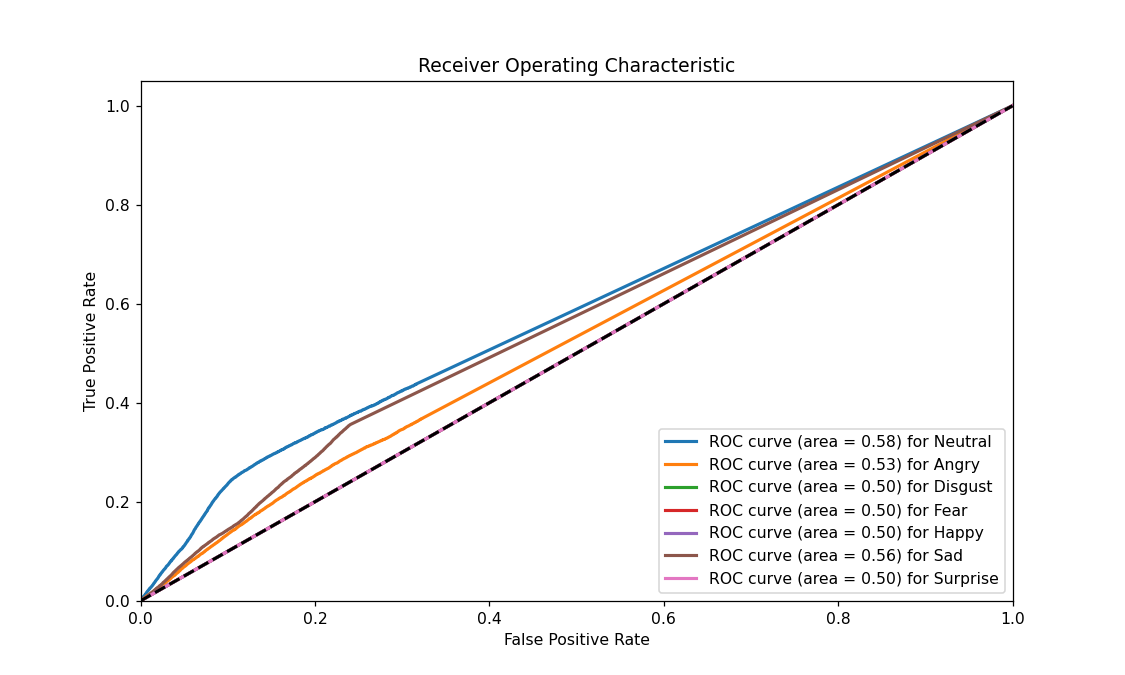

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


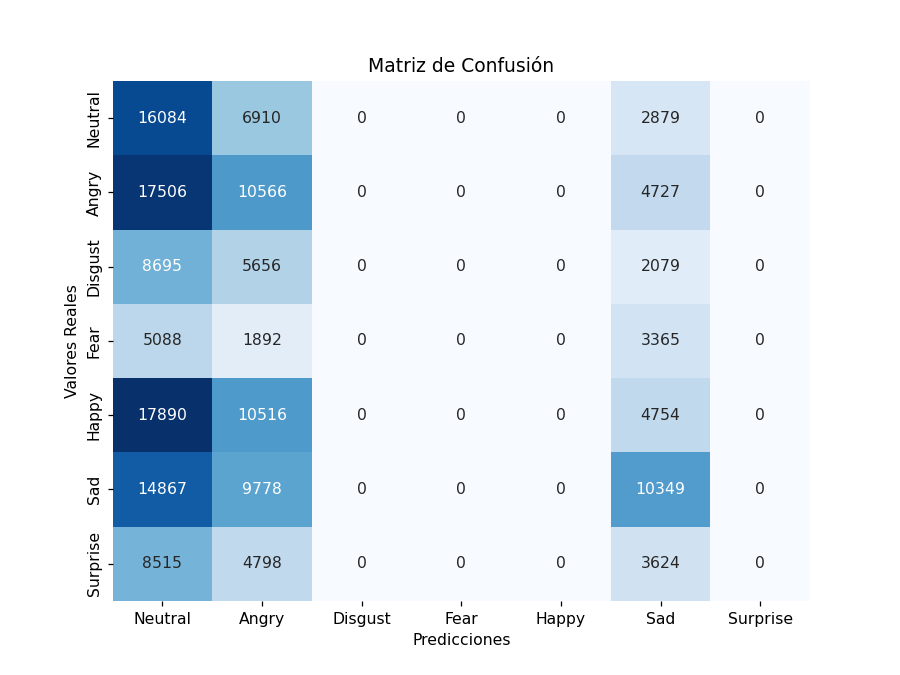

Accuracy: 0.21695457903810295
----------------------------------------------------------------------------------------------
Experimento IXX
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:49<00:00, 213.66it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.158     0.006     0.012     25873
       Angry      0.196     0.595     0.295     32799
     Disgust      0.000     0.000     0.000     16430
        Fear      0.000     0.000     0.000     10345
       Happy      0.256     0.538     0.347     33160
         Sad      0.000     0.000     0.000     34994
    Surprise      0.000     0.000     0.000     16937

    accuracy                          0.220    170538
   macro avg      0.087     0.163     0.093    170538
weighted avg      0.111     0.220     0.126    170538



<IPython.core.display.Javascript object>


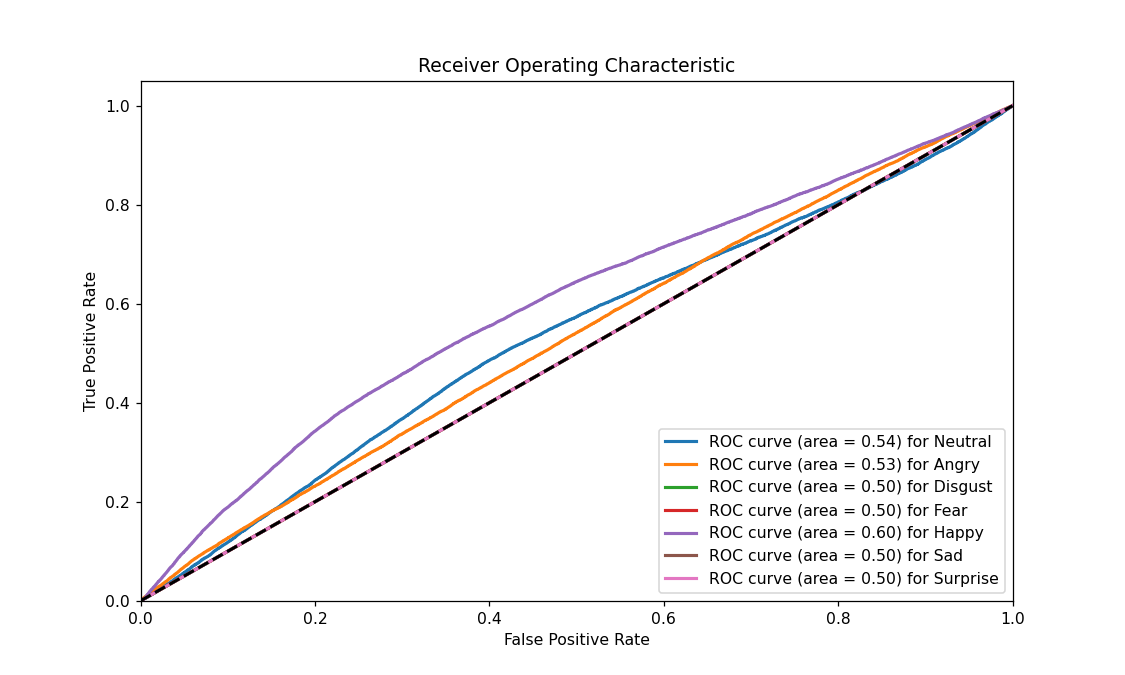

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


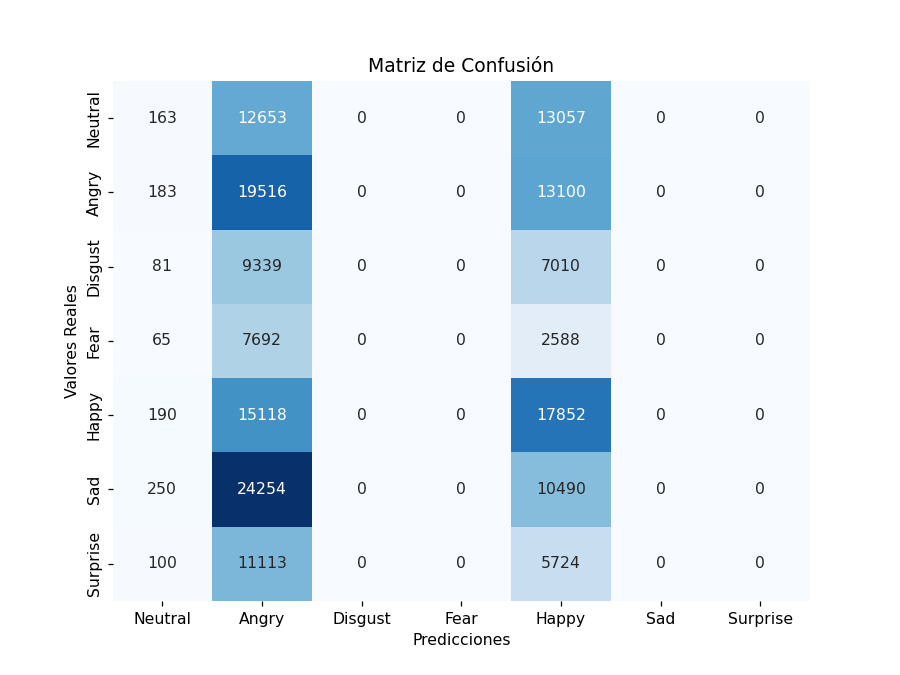

Accuracy: 0.22007411837830865
----------------------------------------------------------------------------------------------
Experimento XAX
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:49<00:00, 213.77it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.000     0.000     0.000     25873
       Angry      0.271     0.007     0.014     32799
     Disgust      0.000     0.000     0.000     16430
        Fear      0.000     0.000     0.000     10345
       Happy      0.195     0.995     0.326     33160
         Sad      0.216     0.001     0.002     34994
    Surprise      0.000     0.000     0.000     16937

    accuracy                          0.195    170538
   macro avg      0.097     0.143     0.049    170538
weighted avg      0.134     0.195     0.067    170538



<IPython.core.display.Javascript object>


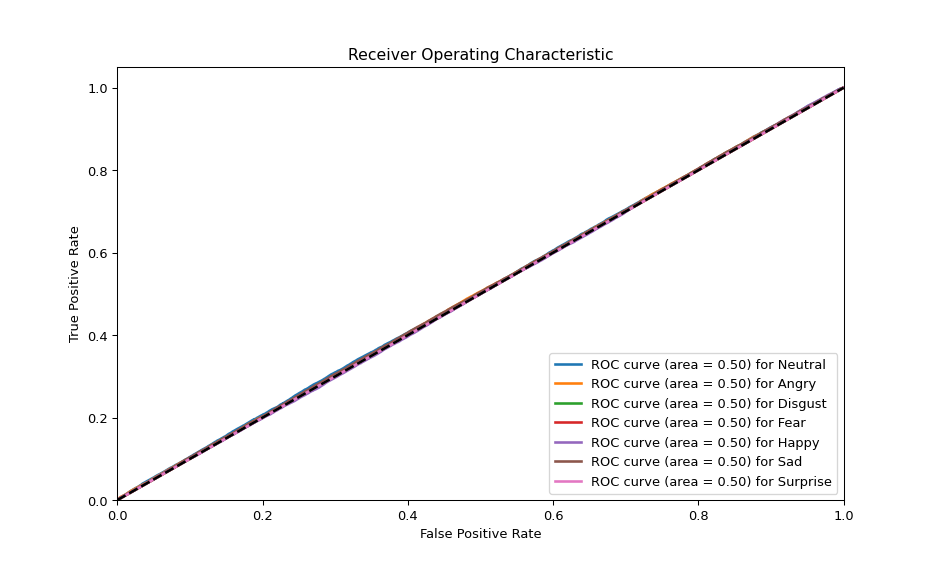

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


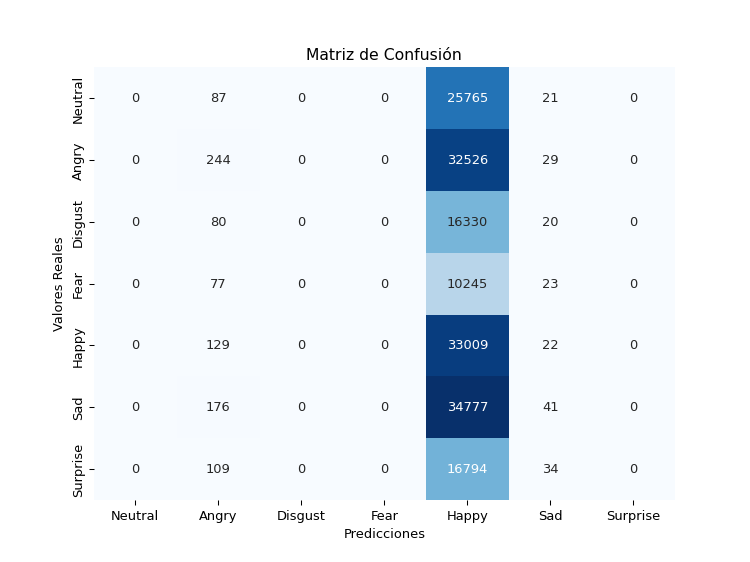

Accuracy: 0.1952292157759561
----------------------------------------------------------------------------------------------
Experimento XXT
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:47<00:00, 223.87it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Neutral      0.179     0.404     0.249     25873
       Angry      0.213     0.327     0.258     32799
     Disgust      0.000     0.000     0.000     16430
        Fear      0.143     0.116     0.128     10345
       Happy      0.279     0.276     0.277     33160
         Sad      0.000     0.000     0.000     34994
    Surprise      0.166     0.204     0.183     16937

    accuracy                          0.205    170538
   macro avg      0.140     0.189     0.156    170538
weighted avg      0.148     0.205     0.167    170538



C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


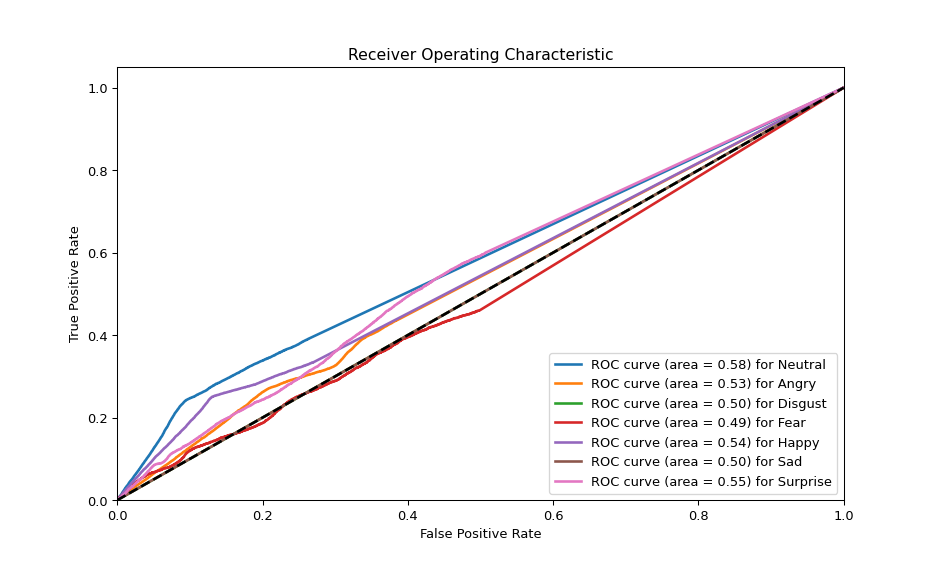

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


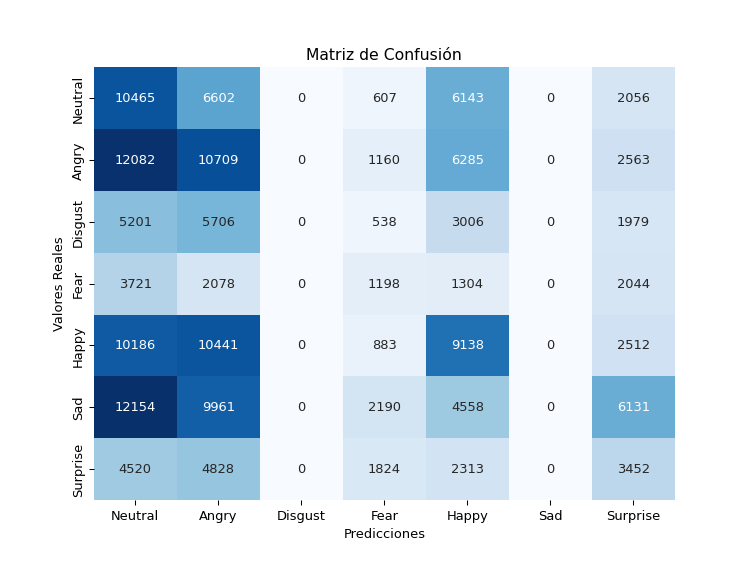

Accuracy: 0.20501002709073637
----------------------------------------------------------------------------------------------
Experimento IAX
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:47<00:00, 224.51it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.077     0.000     0.000     25873
       Angry      0.234     0.123     0.161     32799
     Disgust      0.000     0.000     0.000     16430
        Fear      0.000     0.000     0.000     10345
       Happy      0.254     0.554     0.348     33160
         Sad      0.257     0.594     0.358     34994
    Surprise      0.000     0.000     0.000     16937

    accuracy                          0.253    170538
   macro avg      0.117     0.181     0.124    170538
weighted avg      0.159     0.253     0.172    170538



<IPython.core.display.Javascript object>


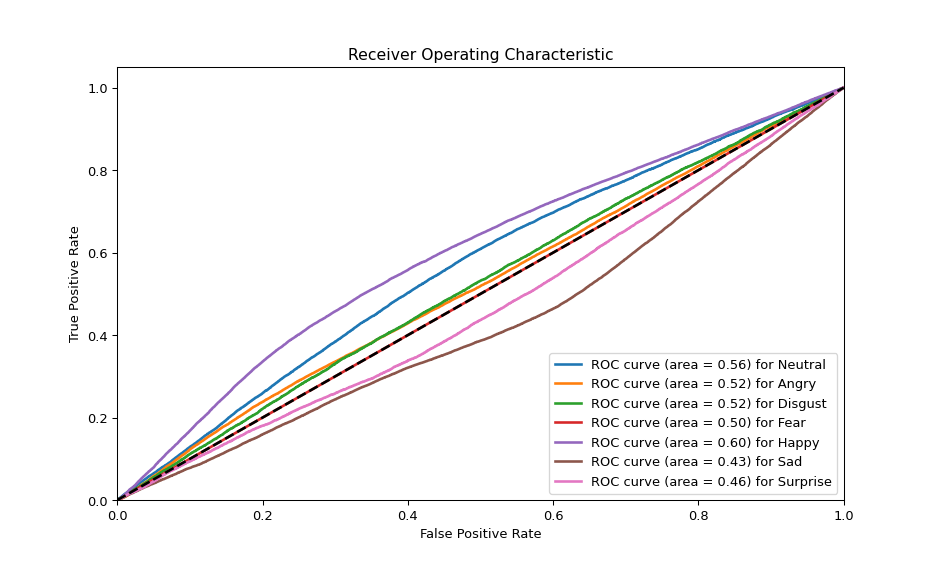

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


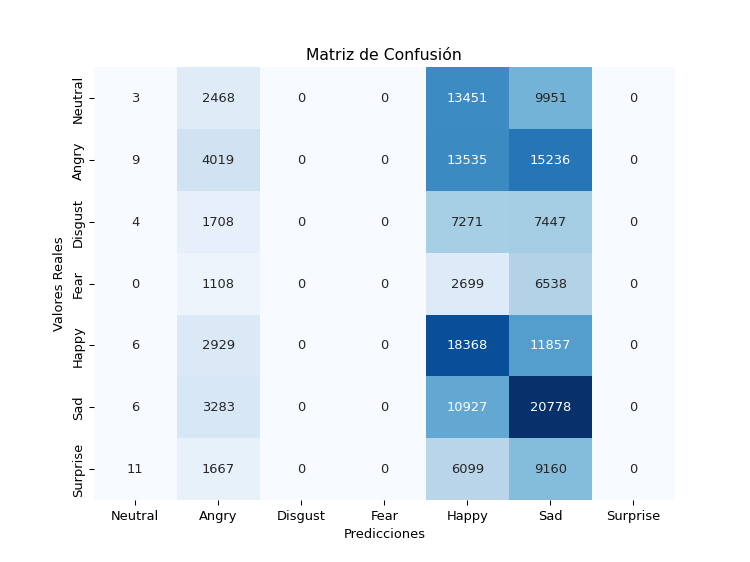

Accuracy: 0.2531283350338341
----------------------------------------------------------------------------------------------
Experimento IXT
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:47<00:00, 224.72it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.197     0.349     0.252     25873
       Angry      0.210     0.315     0.252     32799
     Disgust      0.158     0.118     0.135     16430
        Fear      0.000     0.000     0.000     10345
       Happy      0.281     0.277     0.279     33160
         Sad      0.327     0.286     0.305     34994
    Surprise      0.000     0.000     0.000     16937

    accuracy                          0.237    170538
   macro avg      0.168     0.192     0.175    170538
weighted avg      0.207     0.237     0.217    170538



<IPython.core.display.Javascript object>


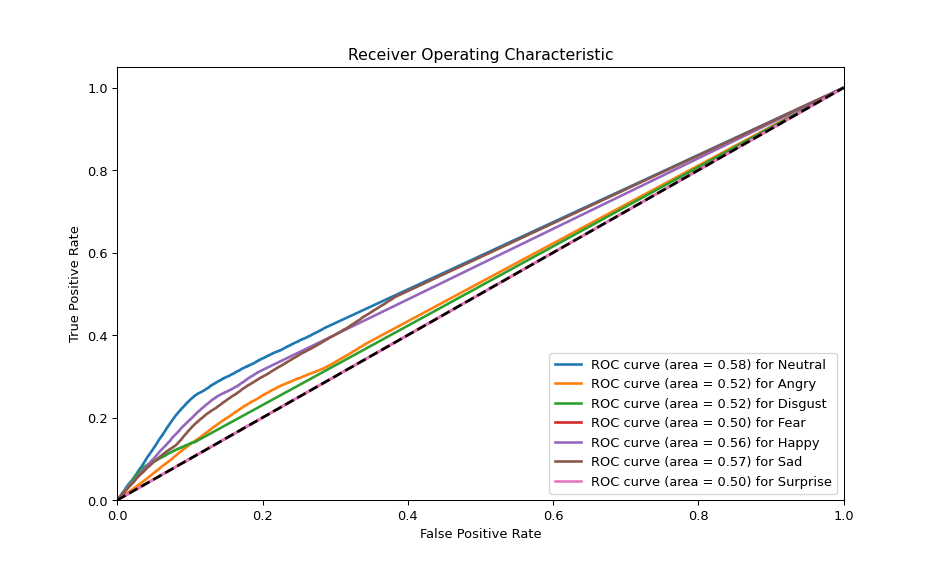

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


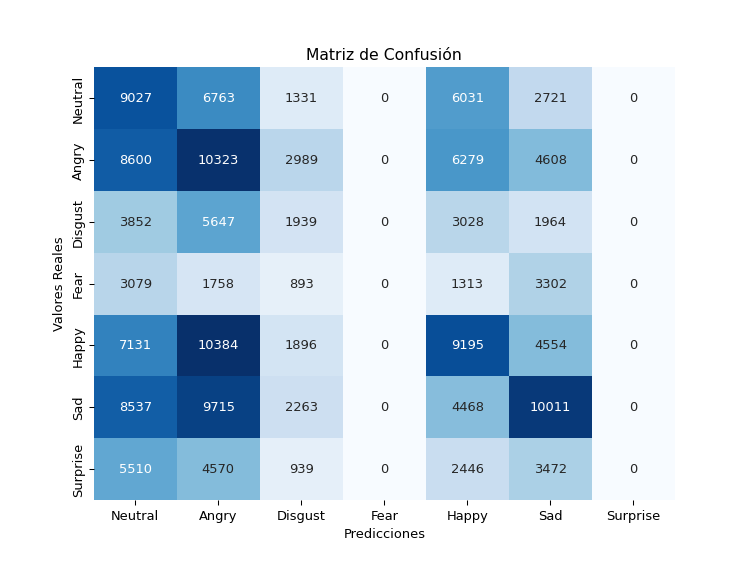

Accuracy: 0.23745440898802614
----------------------------------------------------------------------------------------------
Experimento XAT
395518
170538


Validacion: 100%|███████████████████████████████████████████████████████████████| 10659/10659 [00:52<00:00, 202.39it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.198     0.364     0.256     25873
       Angry      0.215     0.323     0.258     32799
     Disgust      0.156     0.119     0.135     16430
        Fear      0.138     0.103     0.118     10345
       Happy      0.282     0.270     0.276     33160
         Sad      0.000     0.000     0.000     34994
    Surprise      0.166     0.212     0.186     16937

    accuracy                          0.209    170538
   macro avg      0.165     0.199     0.176    170538
weighted avg      0.166     0.209     0.181    170538



<IPython.core.display.Javascript object>


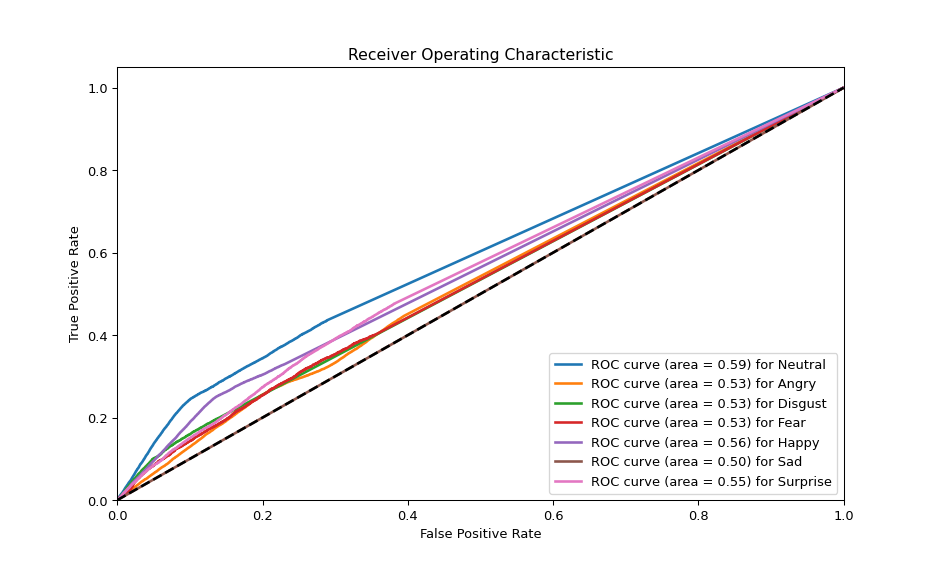

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


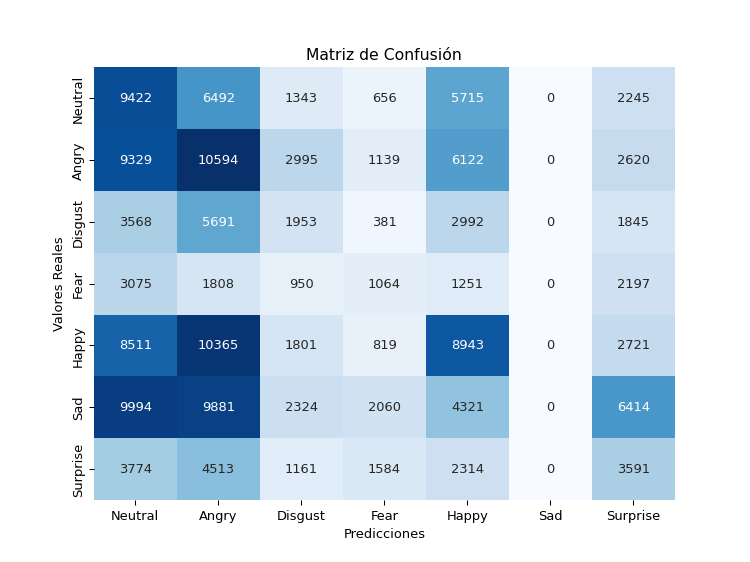

Accuracy: 0.20855762352085752
----------------------------------------------------------------------------------------------


In [85]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

n_epochs = 20
results = dict() 

for ablation in ABLATIONS:
    print(f"Experimento {ablation}")

    trainset = DatasetEmbNet(
        csvfile=train_csv,
        featroot=save_pickle,
        kind='train',
        ablation=ablation,
        transform=FusionTransformer(),
    )

    validset = DatasetEmbNet(
        csvfile=val_csv,
        featroot=save_pickle,
        kind='valid',
        ablation=ablation,
        transform=FusionTransformer(),
    )
    train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=16)

    train_size = len(train_dataloader.dataset)
    valid_size = len(valid_dataloader.dataset)
    print(train_size)
    print(valid_size)
    model = ModelNewFour(**config)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(n_epochs):
        tqdm_train = tqdm(total=len(train_dataloader), desc=f"Train [{epoch+1}/{n_epochs}]")
        train_acc = 0.
        for sample in train_dataloader:
            tqdm_train.update(n=1)
            face_data = sample['image']
            audio_data = sample['audio']
            text_data = sample['text']
            label = sample['label'].squeeze()
            avails = sample['availables']
            pred = model([face_data, audio_data, text_data], avails)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc += (pred.argmax(1) == label).float().sum().item() / train_size
            tqdm_train.set_postfix_str(f"Loss={loss.item():.4f} - Accuracy = {train_acc:.4f}", refresh=True)
        
        tqdm_train.close()
        
        
    all_labels, all_preds = np.empty((0)), np.empty((0, 7))
    model.eval()
    with torch.no_grad():
        for sample in tqdm(valid_dataloader, desc="Validacion"):
            face_data = sample['image']
            audio_data = sample['audio']
            text_data = sample['text']
            label = sample['label'].squeeze() #torch.argmax(, dim=-1)#.flatten()
            avails = sample['availables']

            pred = model([face_data, audio_data, text_data], avails)
            loss = criterion(pred, label)   

            all_labels = np.append(all_labels, label.cpu().numpy(), axis=0)
            all_preds = np.append(all_preds, pred.cpu().numpy(), axis=0)
            
            
    cm = metrics.confusion_matrix(all_labels, all_preds.argmax(1))
    accs_per_emotion = (cm.diagonal() / cm.sum(1))
    weight_acc = (cm.diagonal().sum() / cm.sum())
    
    results[ablation] = (weight_acc, accs_per_emotion)
    print(metrics.classification_report(all_labels, all_preds.argmax(-1), target_names=labelnames, digits=3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    class_names = ['Neutral', 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']    
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Trazar las curvas ROC
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    
    print("----------------------------------------------------------------------------------------------")

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds.argmax(axis=1))

    # Visualizar la matriz de confusión con nombres de clases
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.title('Matriz de Confusión')
    plt.show()
    
    
    accuracy = accuracy_score(all_labels, all_preds.argmax(axis=1))

    print(f'Accuracy: {accuracy}')
    
    print("----------------------------------------------------------------------------------------------")


In [86]:
for key, (wacc, emot) in results.items():
    print(f"{key} = {wacc:.2%}")

IAT = 21.70%
IXX = 22.01%
XAX = 19.52%
XXT = 20.50%
IAX = 25.31%
IXT = 23.75%
XAT = 20.86%
